## ISYE 6402, M 2.4 - Energy Consumption Example

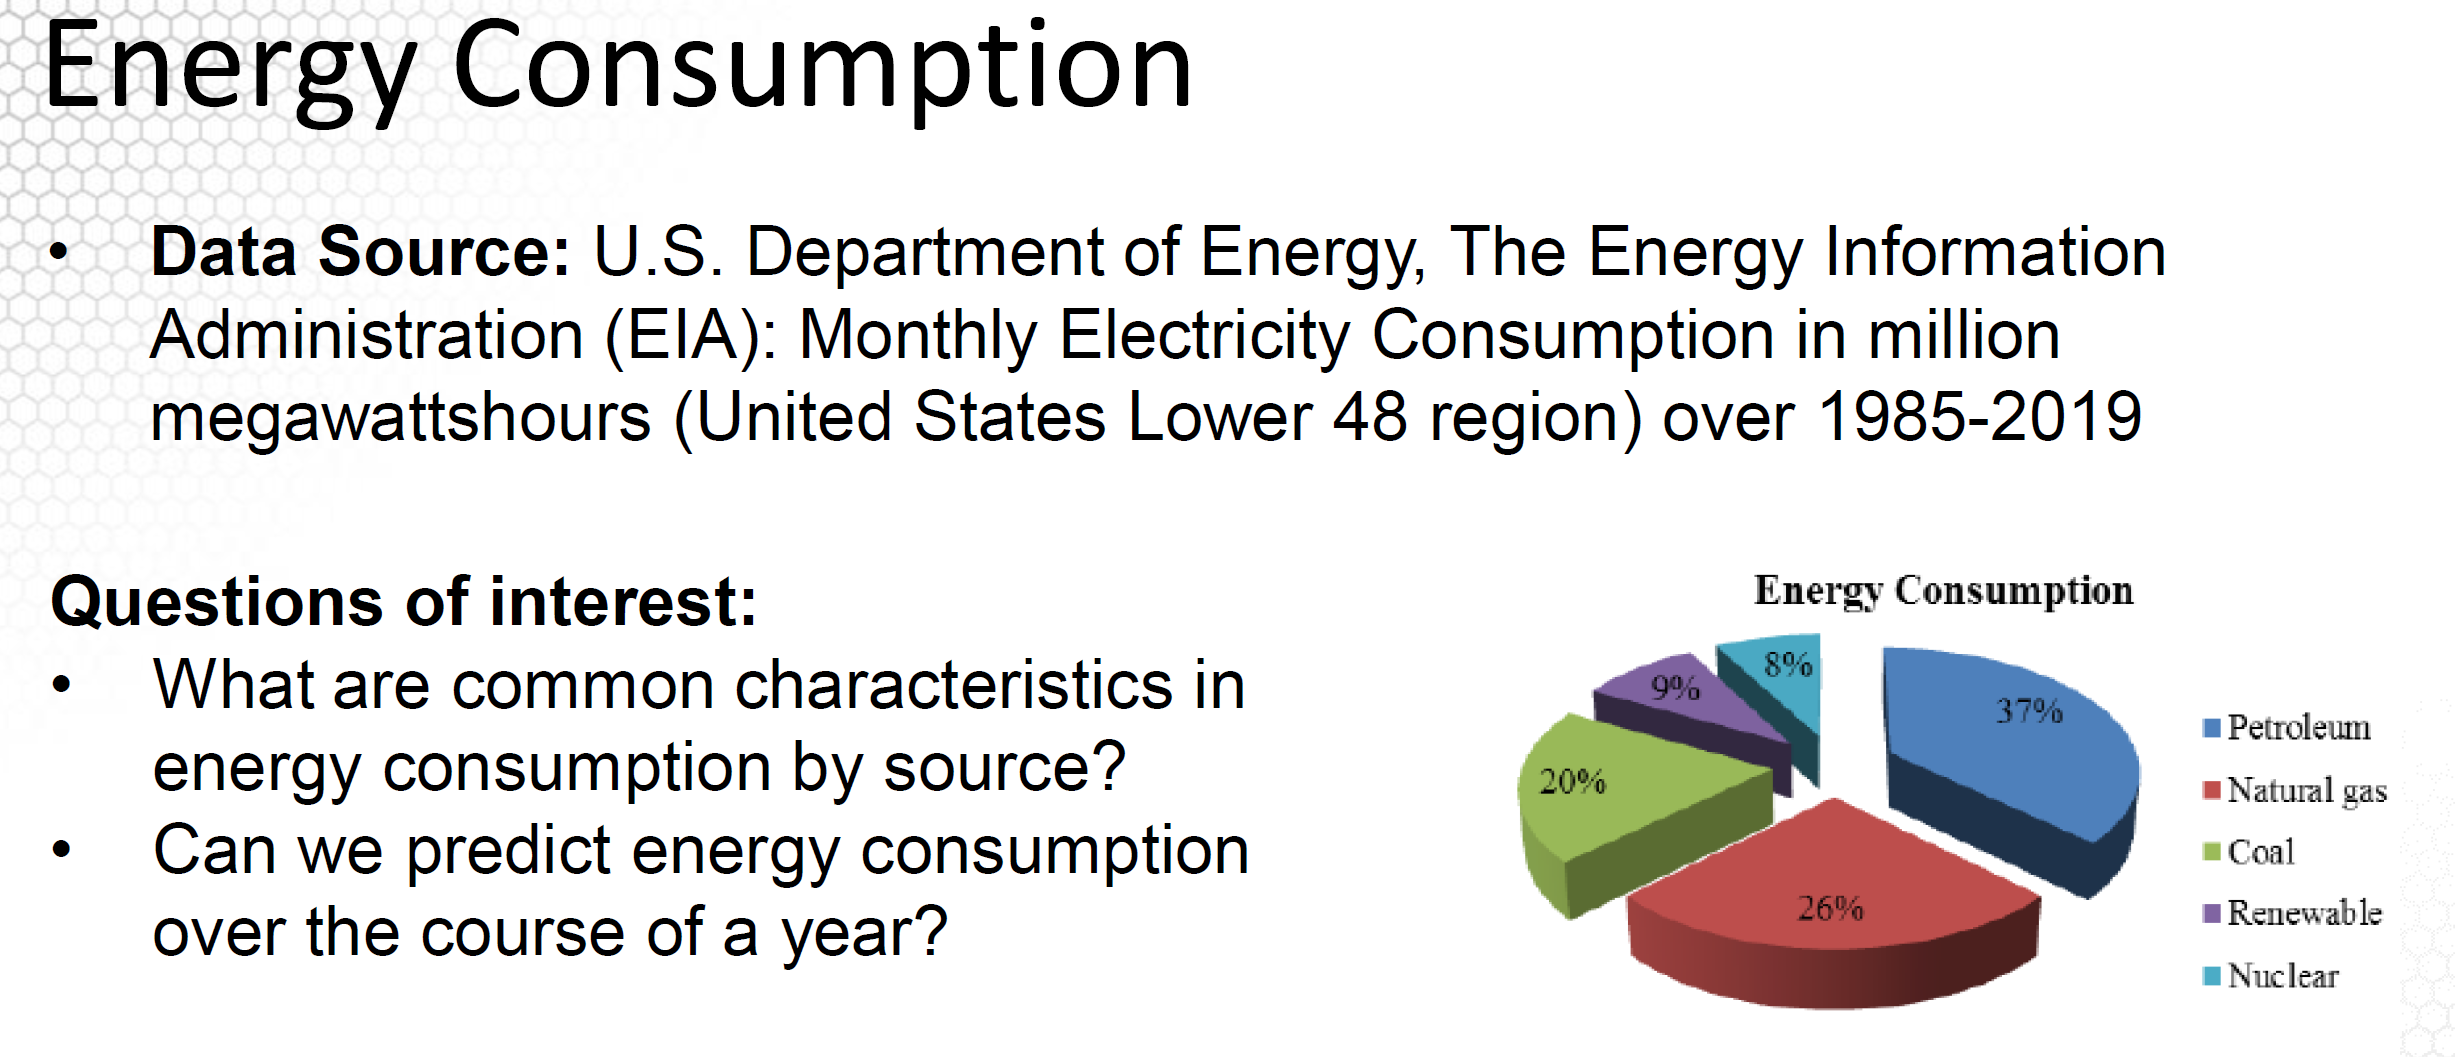

- In this data example, we will focus on monthly electricity consumption data, as it can be used in inferring characteristic on U.S. overall energy consumption. The data were acquired from the U.S. Department of Energy, The Energy Information Administration. 
- The data are available starting 1985 until 2019. The data are available monthly and daily. 
- In this example, we will **analyze the monthly data because the objective here is to perform predictions of electricity consumptions over the upcoming year assuming similar consumption behaviors as in the past years**. 

Of course, this will not be the case of 2020 due to the developments following the covid19 crisis. For this reason, we will evaluate the electricity consumption only until 2019. In this lesson, we will primarily analyze the characteristics of the time series of electricity consumption, for example, evaluate the trend, seasonality and more generally the serial correlation.

In [2]:
################
library(TSA)
library(xts)
library(mgcv)
library(ggplot2)
library(dynlm)
#install.packages('astsa')
library(astsa)
#install.packages('forecast')
library(forecast)
library(lubridate)
###############

### Time Series Plots

Here the command to convert the data into a time series is the xts() command. Here I also transformed the time series using the log-transformation.

In [3]:
options(repr.plot.width=10, repr.plot.height=4)
## Read the data
Electric_Monthly_Consump = read.csv("Electric_Monthly_ConsumpNew.csv")
head(Electric_Monthly_Consump)
dates = as.character(Electric_Monthly_Consump$DATE)
dates = as.Date(dates,format = "%m/%d/%y")
consumption = xts(Electric_Monthly_Consump[,2], as.Date(dates))
head(consumption)
#consumption = ts(Electric_Monthly_Consump[,2],start=1985,freq=12)

,DATE,Value
,<fct>,<dbl>
1,1/1/85,72.5052
2,2/1/85,70.6720
3,3/1/85,62.4502
4,4/1/85,57.4714
5,5/1/85,55.3151
6,6/1/85,58.0904


              [,1]
1985-01-01 72.5052
1985-02-01 70.6720
1985-03-01 62.4502
1985-04-01 57.4714
1985-05-01 55.3151
1985-06-01 58.0904

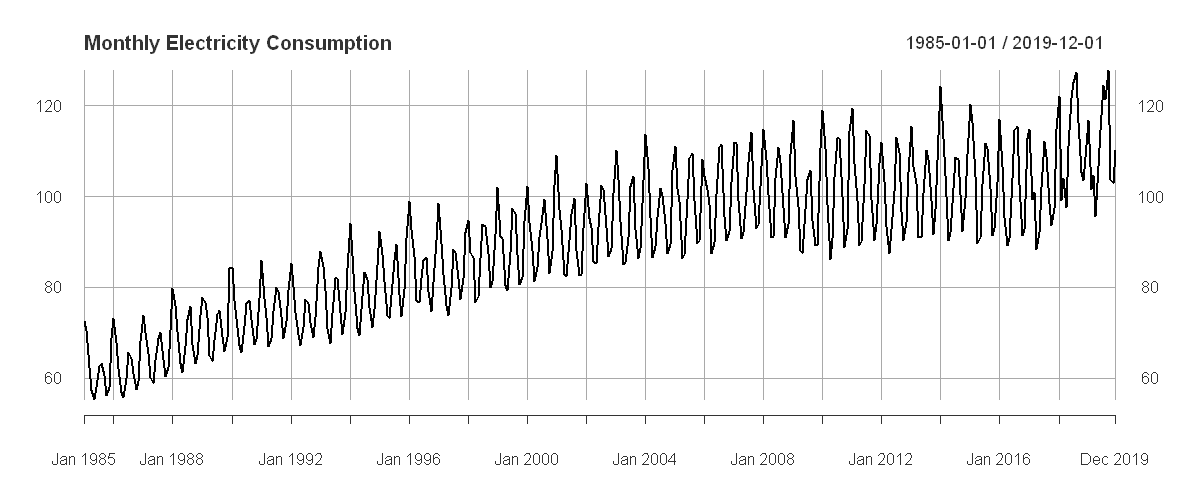

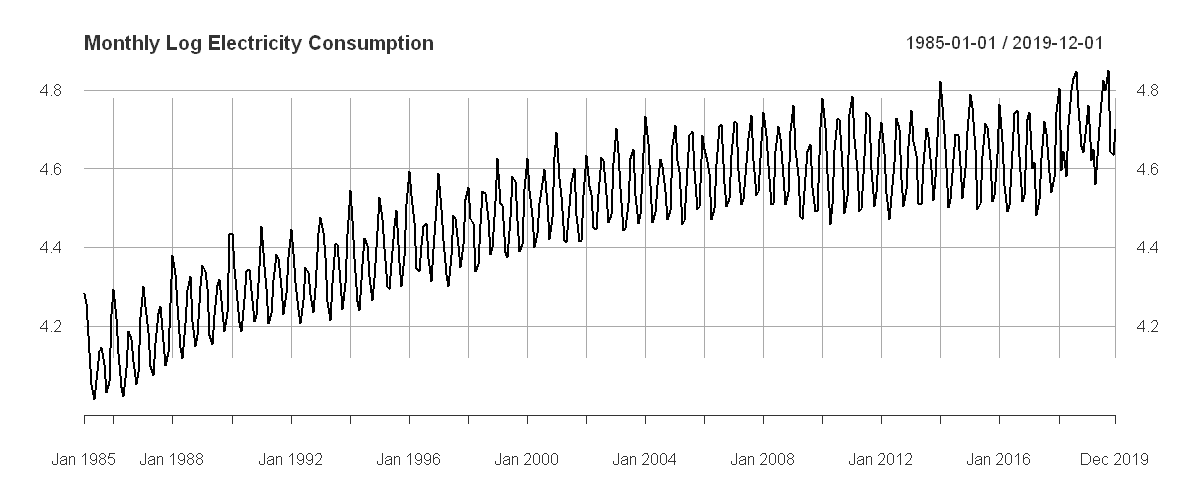

In [4]:
## Read Daily data
#if (FALSE){
#  US_Energy_Daily_Consump = read.csv("Electric_Daily_Consump.csv")
#  dates = as.Date(US_Energy_Daily_Consump$DATE, format="%m/%d/%Y")
#  consumption = xts(US_Energy_Daily_Consump[,2], as.Date(dates))
#}

plot(consumption, main="Monthly Electricity Consumption")

#The time series displays an increasing variability over time
log.consumption = log(consumption)  
log.consumption = xts(log.consumption, as.Date(dates))
plot(log.consumption, main="Monthly Log Electricity Consumption")

- The variance of the original time series depends on time. 
- There is also a clear non-linear trend as well as there is a clear seasonality or cyclical pattern, indicating that the time series is non-stationary.

**The log transformation of the time series is needed to stabilize the time-varying variability before doing trend and seasonality analysis. (Log: Variance Stabilizing Transformation)**

### Why transforming?

### Trend Estimation

- Generally, when removing trend or seasonality, we don't just delete information. 

- As discussed in Module 1, we take that information apart in order to analyze separately each part of the behavior.

- Here are going back to analyzing one component, the trend. 

- You can use your favorite method in Module 1 to capture the trend in the time series. Here we fit spline regression, parametric quadratic polynomial and moving average smoothing to the log transformed time series.

In [5]:
#########################################################
# Exploratory Analysis
#########################################################
## Equally spaced time points
time.pts = c(1:length(index(consumption)))
time.pts = c(time.pts - min(time.pts))/max(time.pts)
## Splines Trend Estimation
#gam.fit = gam(consumption~s(time.pts))
#con.fit.gam = fitted(gam.fit)
gam.fit = gam(log.consumption~s(time.pts))
logcon.fit.gam = fitted(gam.fit)

In [6]:
x1 = time.pts
x2 = time.pts^2
log.lm.fit = lm(log.consumption~x1+x2)
summary(log.lm.fit)


Call:
lm(formula = log.consumption ~ x1 + x2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.174472 -0.072969  0.000184  0.066242  0.194709 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.11937    0.01271  324.23   <2e-16 ***
x1           1.11866    0.05883   19.02   <2e-16 ***
x2          -0.58222    0.05709  -10.20   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08721 on 417 degrees of freedom
Multiple R-squared:  0.7749,	Adjusted R-squared:  0.7738 
F-statistic: 717.6 on 2 and 417 DF,  p-value: < 2.2e-16


In [7]:
mav.fit.log = ksmooth(time.pts, log.consumption, kernel = "box")
temp.fit.mav = ts(mav.fit.log$y,start=1985,frequency=12)

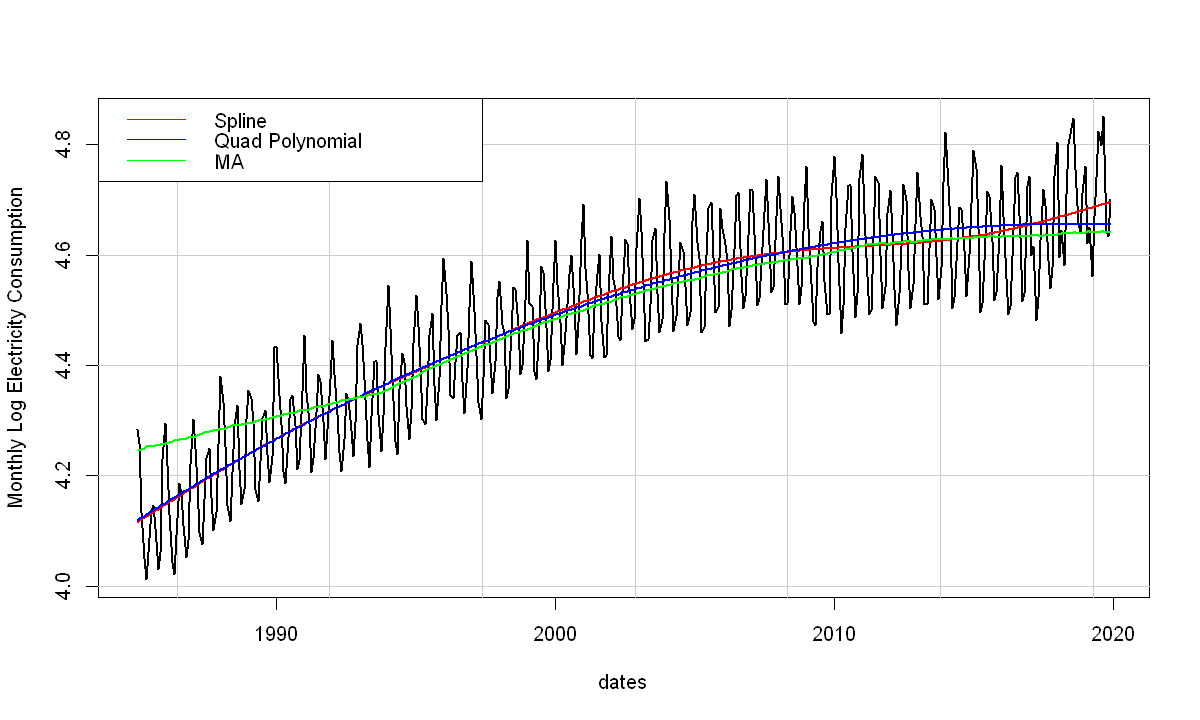

In [8]:
options(repr.plot.width=10, repr.plot.height=6)

## Is there a trend? 
par(mfrow=c(1,1))
#plot(dates,consumption,type='l',lwd=2,ylab="Monthly Electricity Consumption")
#grid(lty=1, col=gray(.8))     
#lines(dates,consumption,lwd=2,ylab="Monthly Electricity Consumption")
#lines(dates,con.fit.gam,lwd=2,col="Brown")
plot(dates,log.consumption,type='l',ylab="Monthly Log Electricity Consumption")
grid(lty=1, col=gray(.8))  
lines(dates,log.consumption,lwd=2)
lines(dates,logcon.fit.gam,lwd=2,col="red")
lines(dates,fitted(log.lm.fit),lwd=2,col="blue")
lines(dates,temp.fit.mav,lwd=2,col="green")
legend('topleft', legend=c("Spline","Quad Polynomial","MA"),lty = 1, col=c("red","blue","Green"))

- Overall, we can observe a positive logarithmic trend in the log-transformed time series. 
- Among the three trend fitting methods, spline seems to best capture the trend. 
- The moving average fit seems to miss the fit at the beginning and at the end of the time period.

### Trend & Quarterly Seasonality

- In addition to the trend fitting, we are quite certain that there is seasonality in the time series as well. 
- Thus, lets capture **trend and seasonality jointly**. Here I used **spline regression to fit the trend and quarterly factor** to capture seasonality


Family: gaussian 
Link function: identity 

Formula:
log.consumption ~ s(time.pts) + seasons - 1

Parametric coefficients:
          Estimate Std. Error t value Pr(>|t|)    
seasonsQ1 4.549463   0.006442   706.2   <2e-16 ***
seasonsQ2 4.411546   0.006438   685.2   <2e-16 ***
seasonsQ3 4.524308   0.006438   702.7   <2e-16 ***
seasonsQ4 4.450629   0.006442   690.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 6.119  7.279 349.5  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.871   Deviance explained =  100%
GCV = 0.0044588  Scale est. = 0.0043514  n = 420

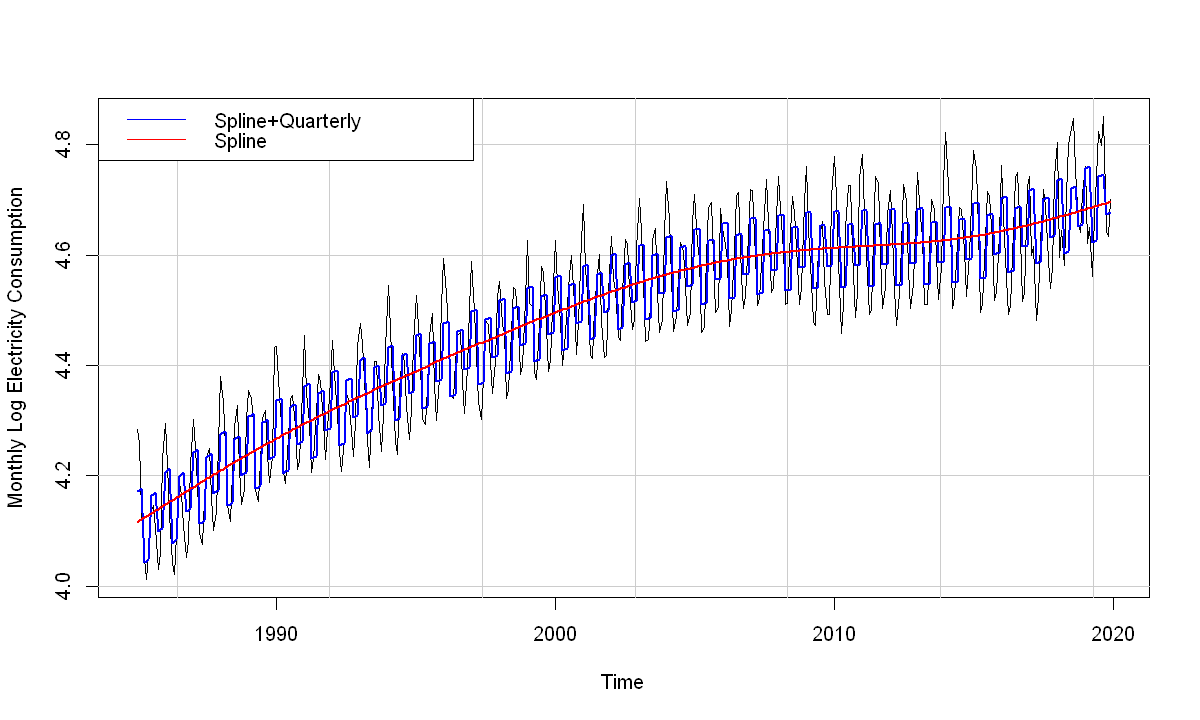

In [9]:
## Trend and seasonality together

# Quarterly
seasons = as.factor(quarters(dates))

#gam.fit.trend.season = gam(consumption~s(time.pts)+seasons-1)
#summary(gam.fit.trend.season)
#fit.gam.seastr = fitted(gam.fit.trend.season)

log.gam.fit.trend.season = gam(log.consumption~s(time.pts)+seasons-1)
summary(log.gam.fit.trend.season)
log.fit.gam.seastr = fitted(log.gam.fit.trend.season)


## Is there a trend and seasonality? 
#plot(as.Date(dates), consumption,type='l',xlab="Time", ylab="Monthly Electricity Consumption")
#lines(as.Date(dates),con.fit.gam,lwd=2,col="Brown")
#lines(as.Date(dates),fit.gam.seastr,lwd=2,col="blue")

plot(as.Date(dates), log.consumption,type='l',xlab="Time", ylab="Monthly Log Electricity Consumption")
grid(lty=1, col=gray(.8))
lines(as.Date(dates), log.consumption)
lines(as.Date(dates),log.fit.gam.seastr,lwd=2,col="blue")
lines(as.Date(dates),logcon.fit.gam,lwd=2,col="red")
legend('topleft', legend=c("Spline+Quarterly","Spline"),lty = 1, col=c("blue","red"))

- Based on the output, we find that the **trend and seasonality are both statistically significant**, 
- however we can see that **some of the seasonality has not be captured**

### Trend & Monthly Seasonality

- The previous slide shows that the trend and quarterly seasonality fit. 
- However, it is possible a monthly seasonality would fit better. 
- Let’s now try to use **monthly factors** instead of quarterly factors to capture seasonality. 


Family: gaussian 
Link function: identity 

Formula:
log.consumption ~ s(time.pts) + seasons_month - 1

Parametric coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
seasons_monthApril     4.377087   0.005775   758.0   <2e-16 ***
seasons_monthAugust    4.554755   0.005774   788.8   <2e-16 ***
seasons_monthDecember  4.550933   0.005777   787.8   <2e-16 ***
seasons_monthFebruary  4.544303   0.005776   786.8   <2e-16 ***
seasons_monthJanuary   4.623954   0.005777   800.4   <2e-16 ***
seasons_monthJuly      4.553869   0.005774   788.7   <2e-16 ***
seasons_monthJune      4.474589   0.005774   775.0   <2e-16 ***
seasons_monthMarch     4.480860   0.005775   775.9   <2e-16 ***
seasons_monthMay       4.383215   0.005774   759.1   <2e-16 ***
seasons_monthNovember  4.416126   0.005776   764.6   <2e-16 ***
seasons_monthOctober   4.384087   0.005775   759.1   <2e-16 ***
seasons_monthSeptember 4.464061   0.005775   773.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**'

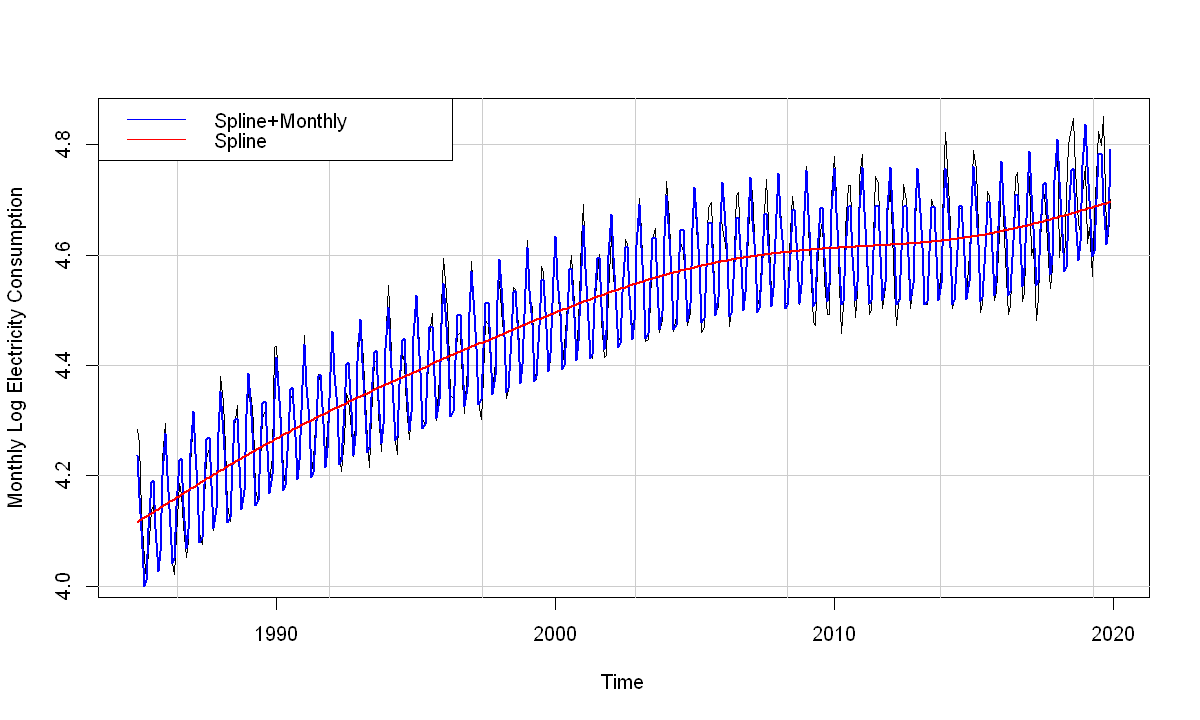

In [10]:
# Monthly
seasons_month = as.factor(months(dates))

log.gam.fit.trend.month = gam(log.consumption~s(time.pts)+seasons_month-1)
summary(log.gam.fit.trend.month)
log.fit.gam.monthtr = fitted(log.gam.fit.trend.month)

plot(as.Date(dates), log.consumption,type='l',xlab="Time", ylab="Monthly Log Electricity Consumption")
grid(lty=1, col=gray(.8))
lines(as.Date(dates), log.consumption)
lines(as.Date(dates),log.fit.gam.monthtr,lwd=2,col="blue")
lines(as.Date(dates),logcon.fit.gam,lwd=2,col="red")
legend('topleft', legend=c("Spline+Monthly","Spline"),lty = 1, col=c("blue","red"))

- At least visually, the **monthly seasonality captures the ups and downs much better than quarterly seasonality**
- Moreover, the monthly factors are all statistically significant, demonstrating that monthly factors produce a better fit for seasonality

#### Fit seasonality and cos-sin after removing trend


Call:
lm(formula = (log.consumption - logcon.fit.gam) ~ har.log - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.166745 -0.022701 -0.000144  0.021658  0.184398 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
har.logcos(2*pi*t)  0.025228   0.002568   9.824  < 2e-16 ***
har.logcos(4*pi*t)  0.101024   0.002568  39.340  < 2e-16 ***
har.logsin(2*pi*t) -0.011147   0.002568  -4.341 1.78e-05 ***
har.logsin(4*pi*t)  0.031431   0.002568  12.240  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03721 on 416 degrees of freedom
Multiple R-squared:  0.8134,	Adjusted R-squared:  0.8116 
F-statistic: 453.2 on 4 and 416 DF,  p-value: < 2.2e-16


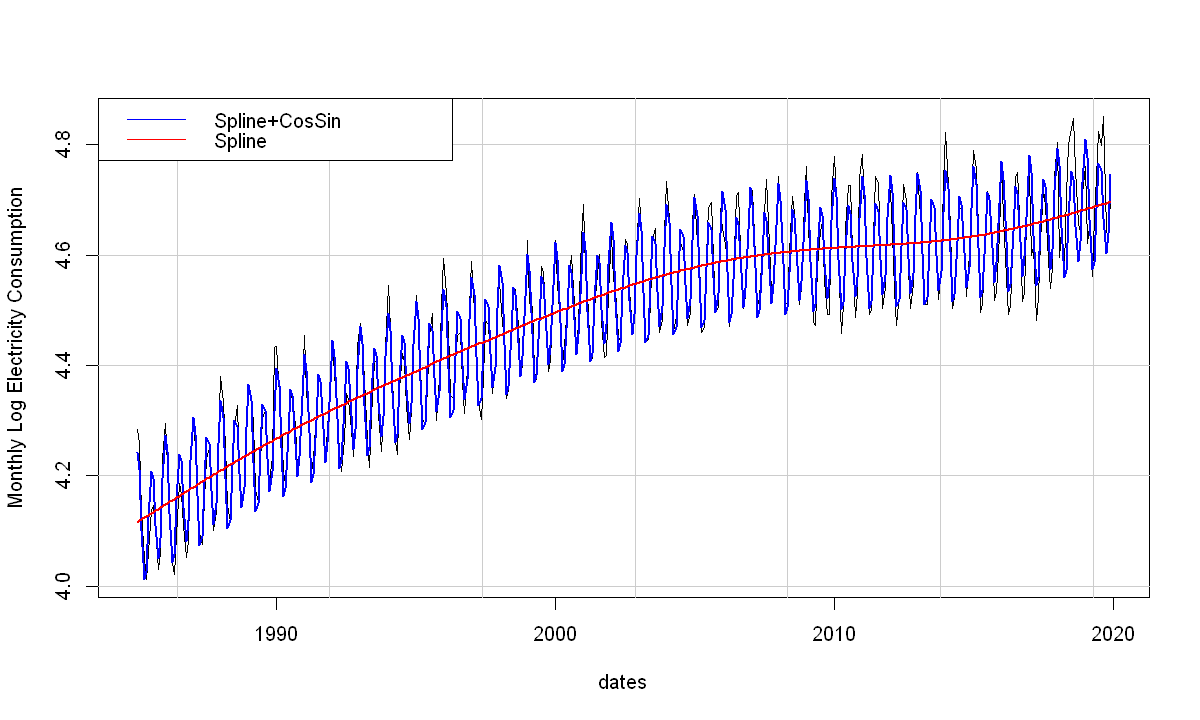

In [11]:
##Fit seasonality and cos-sin after removing trend
## ''harminic' command only takes a 'ts' time series 
log.consumption.ts = ts(log.consumption, start=1985, frequency = 12)
har.log = harmonic(log.consumption.ts,2)
model3.log=lm((log.consumption-logcon.fit.gam)~har.log-1)
summary(model3.log)

plot(dates,log.consumption,type='l',ylab="Monthly Log Electricity Consumption")
grid(lty=1, col=gray(.8))
lines(dates,log.consumption)
lines(dates,fitted(model3.log)+logcon.fit.gam,lwd=2,col="blue")
lines(as.Date(dates),logcon.fit.gam,lwd=2,col="red")
legend('topleft', legend=c("Spline+CosSin","Spline"),lty = 1, col=c("blue","red"))

### Trend & Seasonality: Residual Analysis

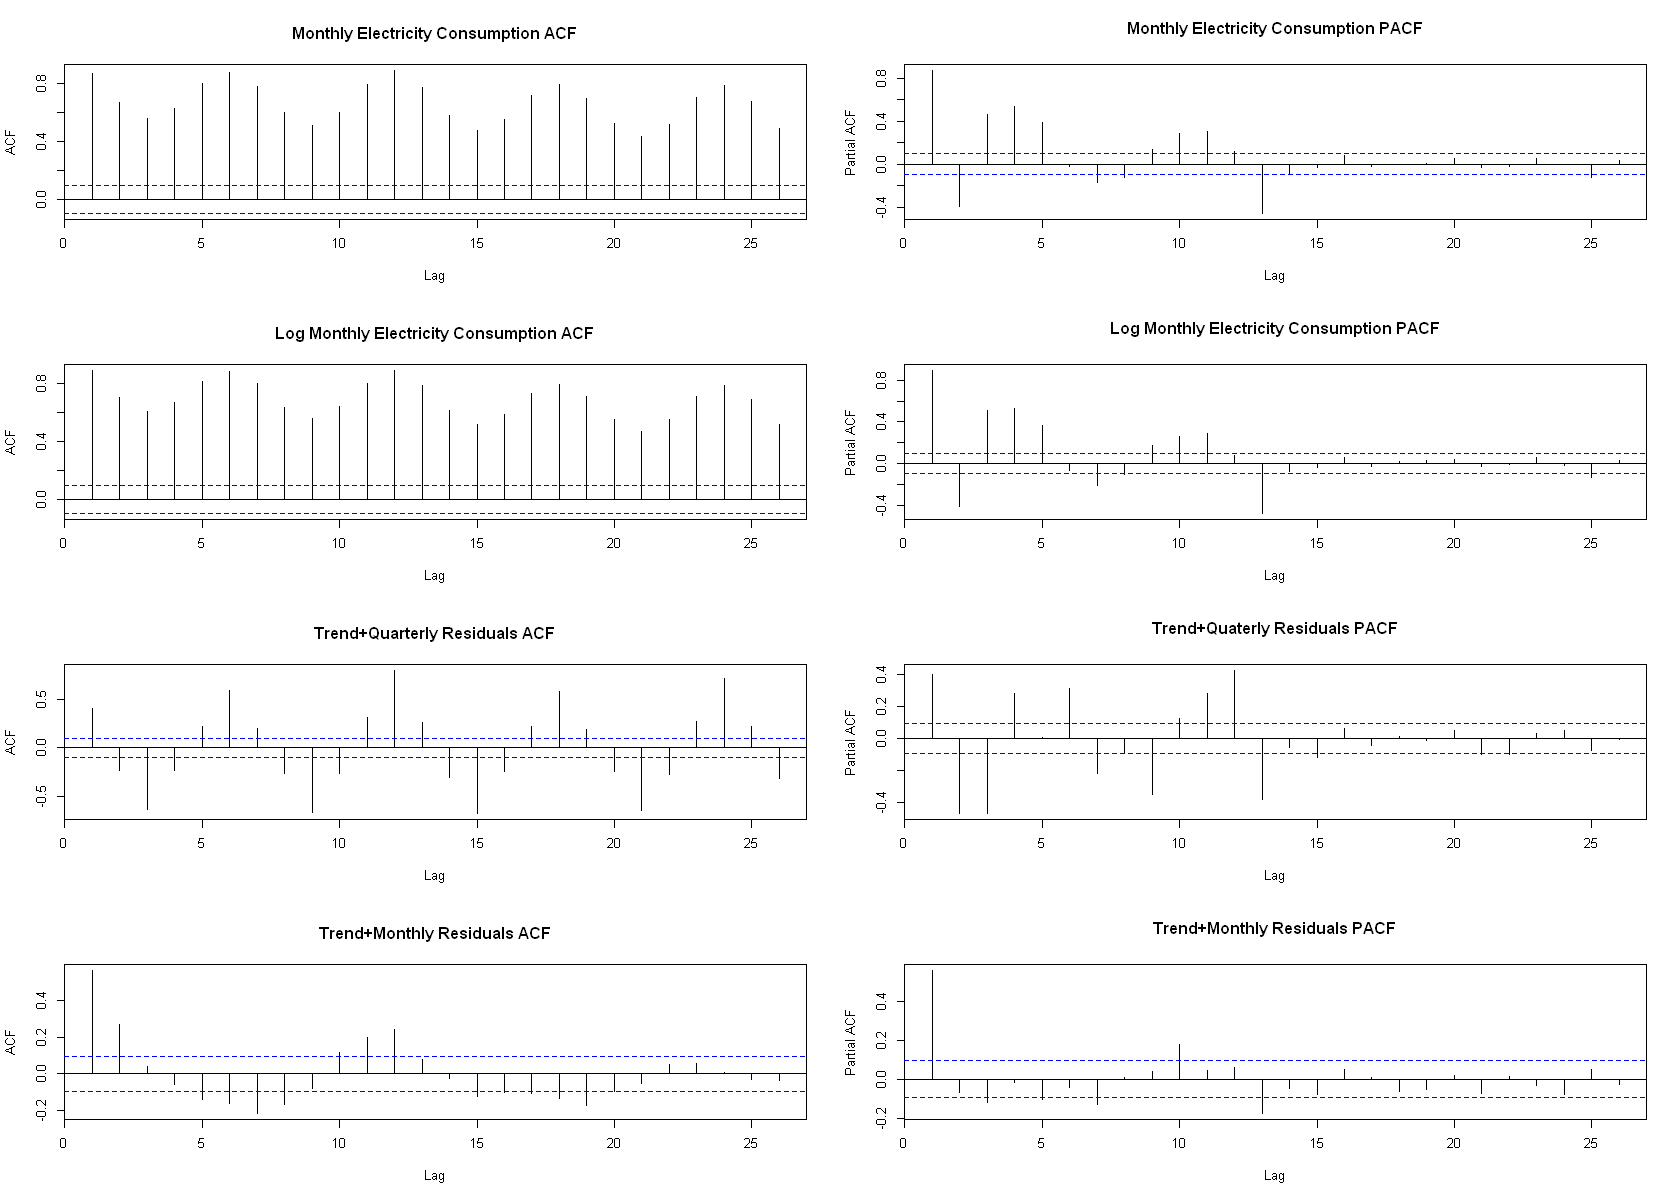

In [12]:
options(repr.plot.width=14, repr.plot.height=10)

## Residual Process: Trend Removal
par(mfrow=c(4,2))

acf(consumption, main="Monthly Electricity Consumption ACF")
pacf(consumption, main="Monthly Electricity Consumption PACF")

acf(log.consumption, main="Log Monthly Electricity Consumption ACF")
pacf(log.consumption, main="Log Monthly Electricity Consumption PACF")

acf(log.consumption-log.fit.gam.seastr, main="Trend+Quarterly Residuals ACF")
pacf(log.consumption-log.fit.gam.seastr, main="Trend+Quaterly Residuals PACF")

acf(log.consumption-log.fit.gam.monthtr, main="Trend+Monthly Residuals ACF")
pacf(log.consumption-log.fit.gam.monthtr, main="Trend+Monthly Residuals PACF")

#acf(log.consumption-fitted(model3.log)-logcon.fit.gam, main="Trend+CosSin Residuals ACF")
#pacf(log.consumption-fitted(model3.log)-logcon.fit.gam, main="Trend+CosSin Residuals ACF")

- ACF and PACF plots for the original, log-transformed time series and the residuals of the two models are shown.
- We can see that “trend+quarterly seasonality” residuals **still contain seasonality in the acf and pacf pots**.
- The acf plots for the **“trend+monthly seasonality” residuals show that there is still some seasonality pattern although most of the sample auto-correlation and partial auto-correlation values are within the confidence bands or close to the confidence bands**.
- It is possible that there are still some seasonality factors not captured by either monthly seasonality. This might due to temperature changes and environment behaviors that could impact people’s electricity consumptions in each year.

### Energy Consumption: Forecasting

will compare the predictions based on two forecasting approaches, 
1. one being the ARMA model applied to the residuals after fitting trend and monthly seasonality and 
2. the second being the seasonal ARIMA

### Assessing Stationarity

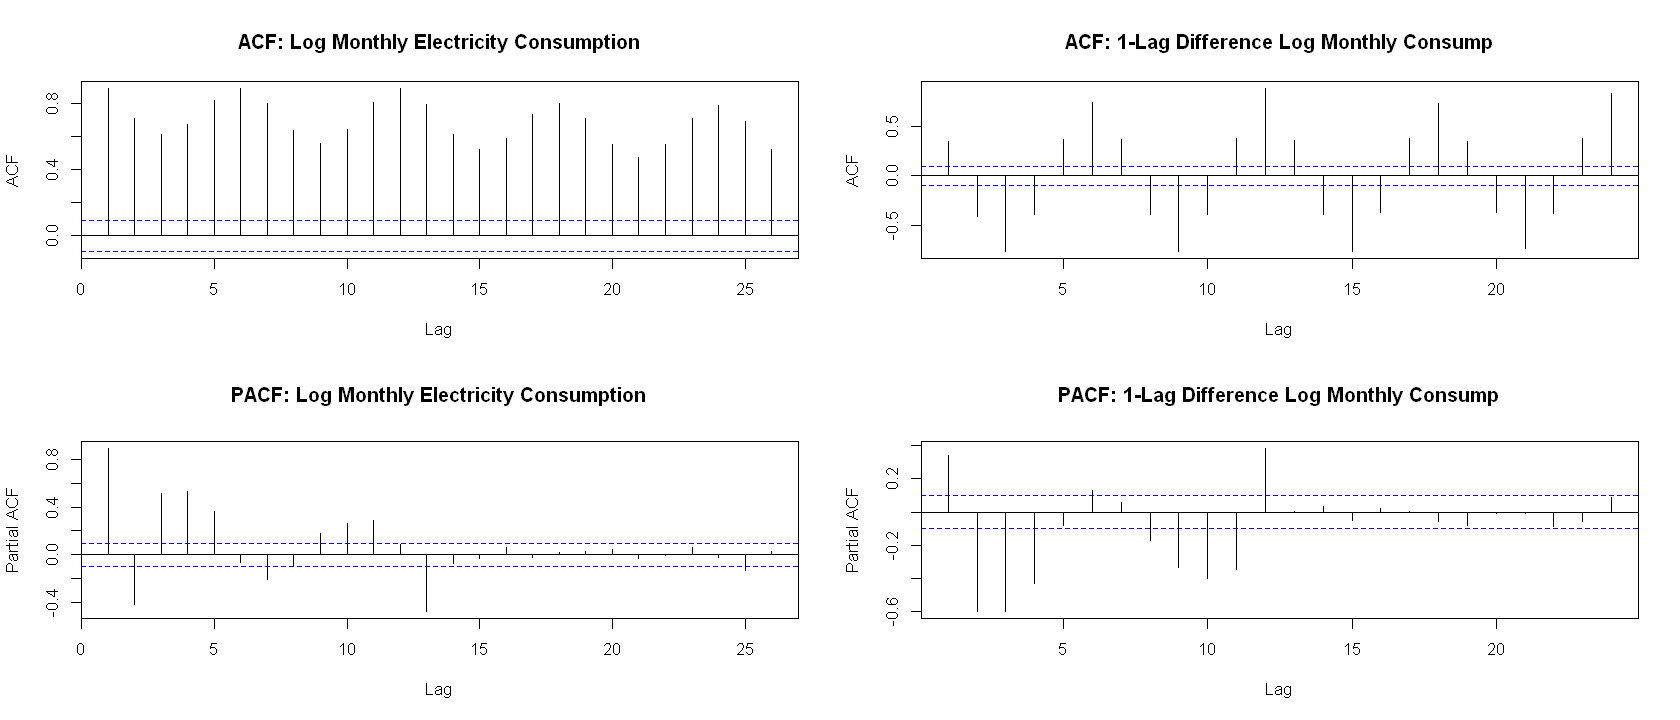

In [13]:
#########################################################
#Module 2 Material
#########################################################
#Take the difference
diff.consump.1 <- diff(log.consumption,1)
#diff.consump.1 = na.omit(diff.consump.1)

diff.consump.1 <- diff.consump.1[-c(1:12)]

options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(2,2))

acf(log.consumption, main="ACF: Log Monthly Electricity Consumption")
acf(diff.consump.1,24,main="ACF: 1-Lag Difference Log Monthly Consump")

pacf(log.consumption, main="PACF: Log Monthly Electricity Consumption")
pacf(diff.consump.1,24,main="PACF: 1-Lag Difference Log Monthly Consump")

- Returning now to the analysis of the log-tranformed data, displaying here the ACF and PACF plots of the log transformed time series on the left and the 1 lag difference of the time series on the right. 
- The **slow decay in the ACF is a sign of non-stationarity**; in fact, we did identify a trend and seasonality in the data hence this result is not surprising. 
- But we can see that even with the **first order differencing, we observe that there is a pattern in the ACF plots, with large values following a seasonal pattern. This thus suggests a seasonal difference would need to be applied**.

### Assessing Stationarity: Trend & Seasonality

Next we are analyzing the 12-lag difference time series to account for seasonality. The R code for this differencing along with the corresponding plots is here

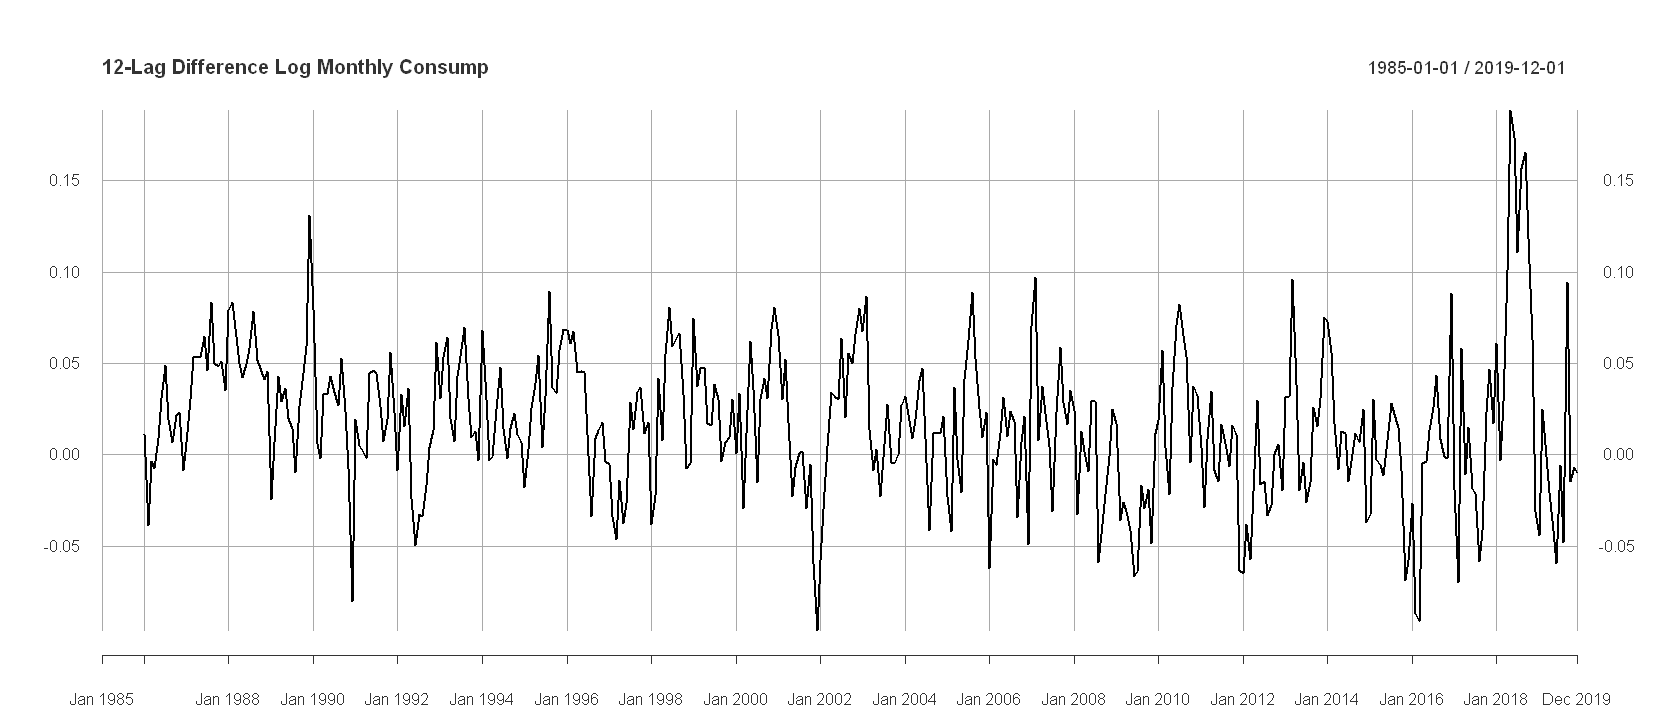

In [14]:
#Take the difference
diff.consump <- diff(log.consumption,12)

plot(diff.consump, main="12-Lag Difference Log Monthly Consump")
grid(lty=1, col=gray(.8))
lines(dates,diff.consump,lwd=5)

**The seasonality seemed to have been removed with the differencing, with no distinguishable pattern in the time series as shown in the time series plot**

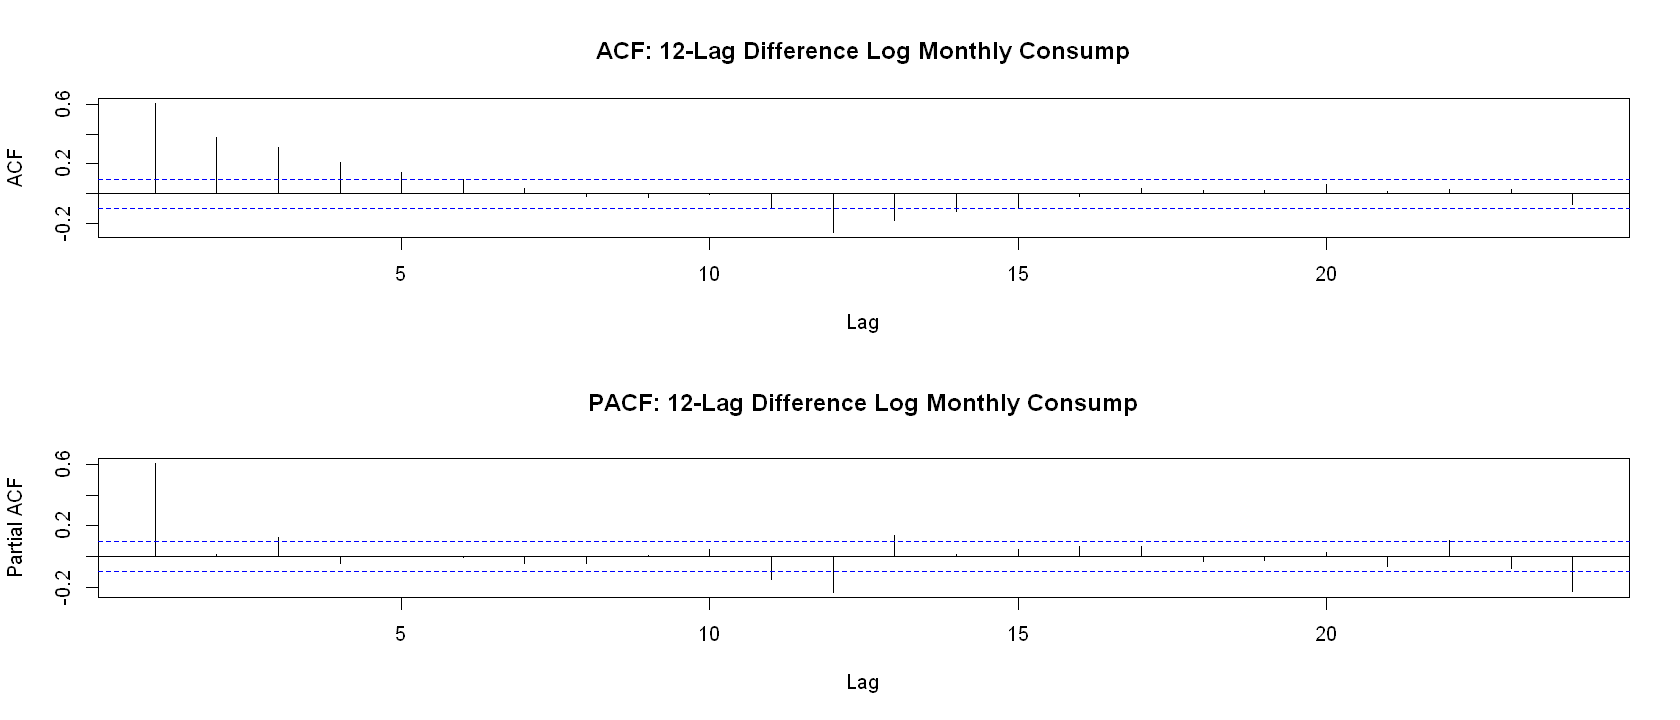

In [15]:
diff.consump <- diff.consump[-c(1:12)]

par(mfrow=c(2,1))
acf(diff.consump,24,main="ACF: 12-Lag Difference Log Monthly Consump")
pacf(diff.consump, 24,main="PACF: 12-Lag Difference Log Monthly Consump")

- The ACF/PACF plots of the 12-lag difference of the log monthly electricity consumption are similar with the ACF/PACF plots of the residuals from the “spline+monthly seasonality” model.
- **Thus, we can model further with the ARMA model either the difference process or the residuals from the “spline+monthly seasonality” model**. 
- Here we will use 12-lag difference of the log monthly electricity consumption for ARIMA modeling.

### Difference Time Series: ARMA Model

Now, we are ready to model the residual process of the log monthly electricity consumption with ARMA models. This is the code we used before for order selection applied this time to the 12-lag difference of the log-transformed data for the monthly electricity time series.

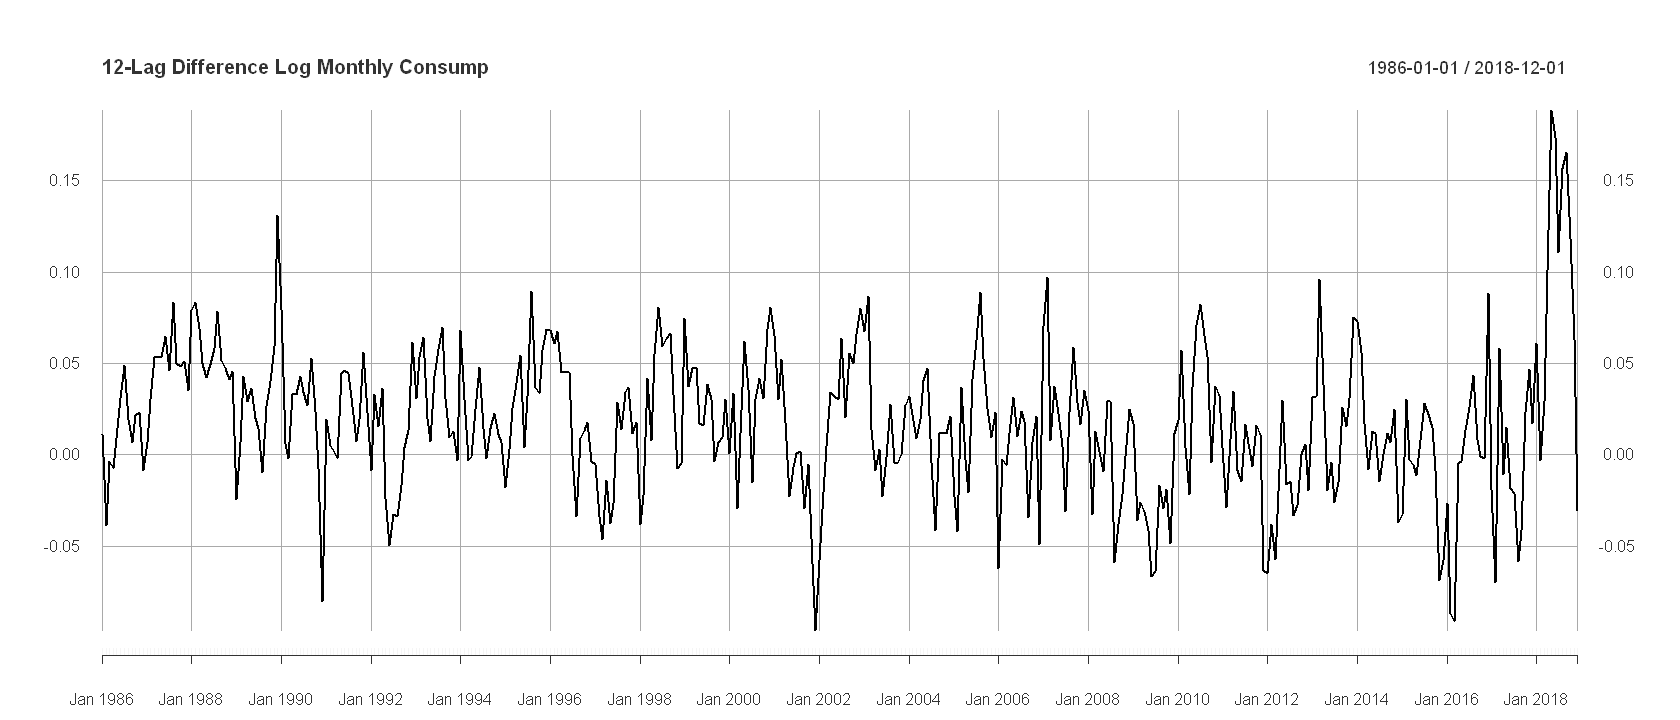

In [16]:
## Divide data into training (except last year) & testing (last year)

## !!!! n_forward=12 not converging with d = 1 but n_forward= 52 is as given in original code!!!!!
n_forward=12
n = length(diff.consump)
nfit = n-n_forward
diff.consump.train = diff.consump[1:nfit]

plot(diff.consump.train, main="12-Lag Difference Log Monthly Consump")
grid(lty=1, col=gray(.8))

In [17]:
## !!!! n_forward=12 not converging with d = 1 but n_forward= 52 is as given in original code!!!!!

## Fit an ARMA model to the 12-lag difference time series with *d=1* 
n = length(diff.consump.train) 
norder = 13
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)

for(i in 1:norder){
  for(j in 1:norder){
    modij = stats::arima(diff.consump.train,order = c(p[i],1,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
  }  
}
# Extract the "best" one according to AIC
aicv <- as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp <- rep(c(1:norder),norder)
indexq <- rep(c(1:norder),each=norder)
indexaic <- which(aicv == min(aicv))
porder <- indexp[indexaic]-1
qorder <- indexq[indexaic]-1

Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 1, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 1, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 1, q[j]), method = "ML")

ERROR: Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE, : non-finite finite-difference value [9]


In [20]:
min(aicv)
porder
qorder

ERROR: Error in eval(expr, envir, enclos): object 'aicv' not found


**The selected orders are p= 8; q = 12 assuming we also apply a one order difference to account for any other potential trend in the data.**

#### If instead we take d=0, that is, we don’t apply yet another difference

Warning message in stats::arima(diff.consump.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(diff.consump.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(diff.consump.train

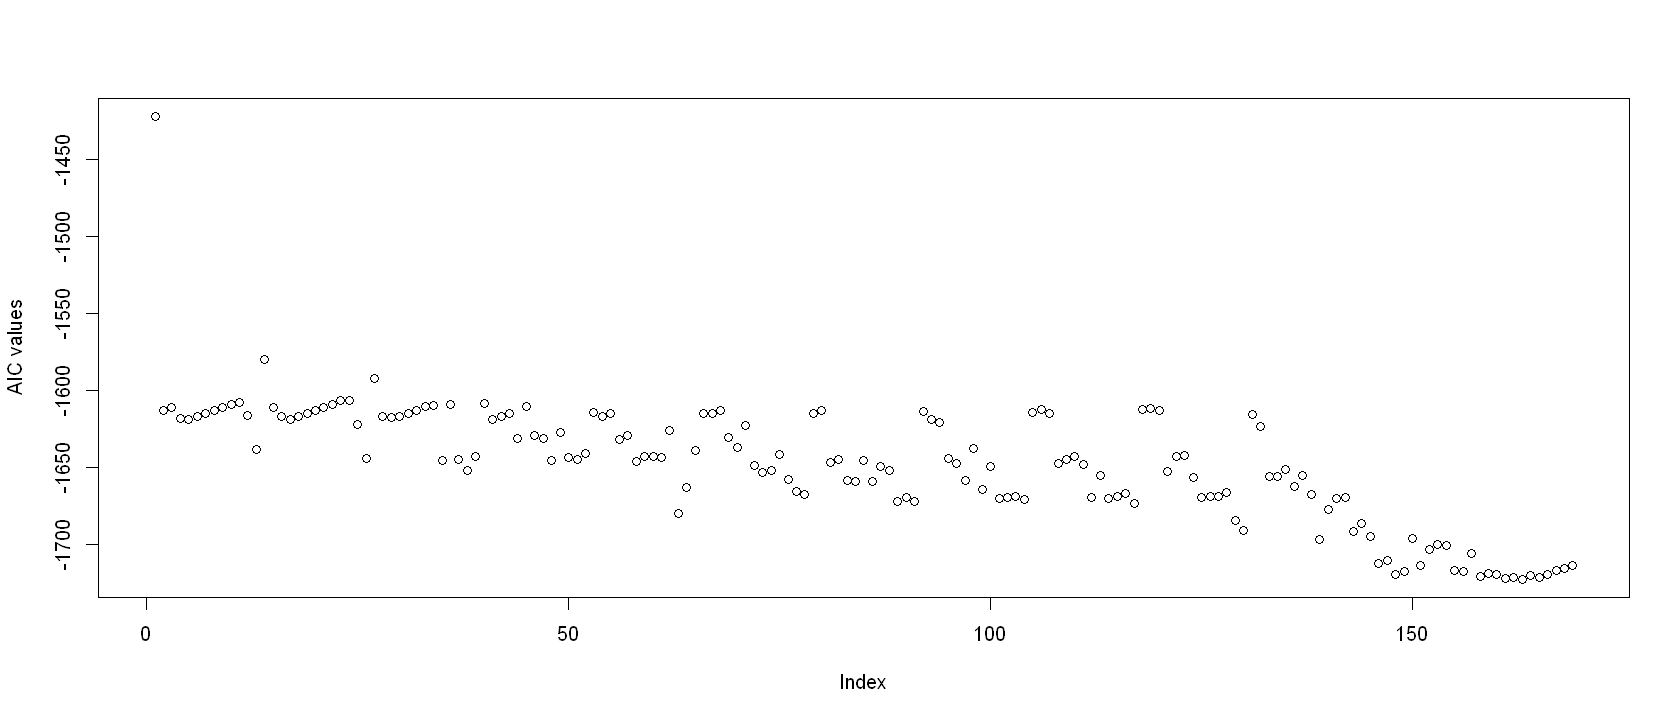

In [21]:
## Fit an ARMA model to the 12-lag difference time series with *d=0* 
n = length(diff.consump.train) 
norder = 13
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)

for(i in 1:norder){
  for(j in 1:norder){
    modij = stats::arima(diff.consump.train,order = c(p[i],0,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
  }  
}
# Extract the "best" one according to AIC
aicv <- as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp <- rep(c(1:norder),norder)
indexq <- rep(c(1:norder),each=norder)
indexaic <- which(aicv == min(aicv))
porder <- indexp[indexaic]-1
qorder <- indexq[indexaic]-1

In [22]:
min(aicv)
porder
qorder

[1] -1722.701

[1] 6

[1] 12

- then the selected orders are p= 4; q = 12. (porder did not match from lesson)

A few observations are to be noted.

- I will also highlight that I divided the data into training and testing data, where the testing data consists of the monthly observations from 2019, that is, one year of data. (Not coverging with one yr data, need to check)

- I applied the arima modeling including model selection on the training data. The testing data will be used to evaluate the prediction accuracy. 

- The model with d=1 does not perform better than the model with d=0 when comparing the AICC values. 

- Moreover, the model with d=0 is less complex since the AR order is 4, lower than the previous model. For the rest of the analysis, I will use this model.

### ARMA Model: Residual Analysis

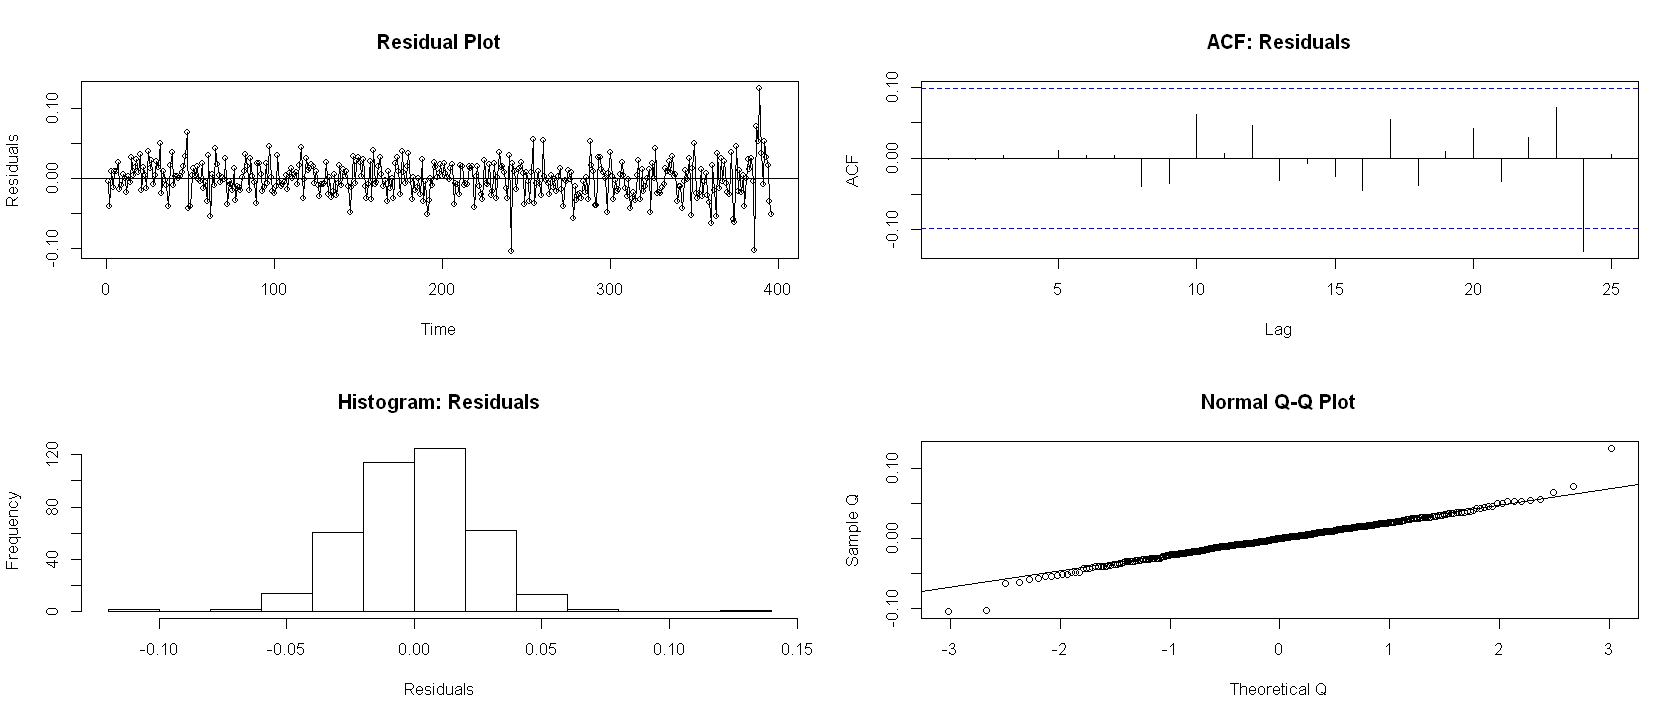

In [23]:
# Fit the "best" arima model
final_model <- arima(diff.consump.train, order = c(porder,0,qorder), method = "ML")

## GOF: residual analysis
par(mfrow=c(2,2))
resids <- resid(final_model)
plot(resids, ylab='Residuals',type='o',main="Residual Plot")
abline(h=0)
acf(resids,main="ACF: Residuals")
#pacf(resids,main="ACF: Residuals")
hist(resids,xlab='Residuals',main='Histogram: Residuals')
qqnorm(resids,ylab="Sample Q",xlab="Theoretical Q")
qqline(resids)

**The residuals seem to behave like a white noise with a normal distribution. The normality is assessed using the quantile-quantile normal plot and the histogram on the bottom.**

### Time Series: SARIMA Model

Next I applied an SARIMA or seasonal ARIMA model to the log-transformed data. The selected model is an ARMA with orders p= 3; d=0; q = 12 and SARIMA with orders sp =1; sd= 1; sq = 1. Selecting the orders for the SARIMA is time consuming; for that, I considered only small orders for the seasonal component of the model. I also note here that the ‘sarima’ command here does not converges for all combinations of the ARMA orders. For example, the SARIMA does not converge for an AR order larger than 9 hence for I restricted here to a ‘porder’ taking values from 0 to 9. The code provided on the slide is for sp=1, sd=1 and sq=0. While here the code includes all combinations of p and q, as you will run the code, you will find that the code will stop for some combinations of (p,q). You will have to exclude these combinations then run the code again.

In [24]:
#### SARIMA Fit ##########################

norder=13
sorder=2
p = c(1:norder)-1; q = c(1:norder)-1
sp = c(1:norder)-1; sq = c(1:norder)-1
nfit.sarima=length(log.consumption.ts)-12
n = length(log.consumption)
log.consump.train=log.consumption.ts[1:nfit.sarima]

## hgher AR orders than 9 result in lack of convergence hence run the code for i in 1:10
## Select order for SARIMA: p = 0,.., 9; q = 0,..,12; *sp=0; qp=1*
aic_sarima_01=matrix(0,10,norder) 
for(i in 1:norder){
  for(j in 1:norder){
    sarima_model_select1 = astsa::sarima(log.consump.train, p[i], 0, q[j], sp[1], 1, sq[2], 12, details=FALSE, Model=FALSE)
    aic_sarima_01[i,j] = sarima_model_select1$AIC
  }
}

Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = 

ERROR: Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE, : non-finite finite-difference value [9]


In [25]:
## hgher AR orders than 9 result in lack of convergence hence run the code for i in 1:10
## Select order for SARIMA: p = 0,.., 9; q = 0,..,12; *sp=0; qp=1*
## For some combinations of (p,q) orders, the SARIMA model does not converge
## you will need to skip those combinations
aic_sarima_10=matrix(0,10,norder) 
for(i in 1:norder){
  for(j in 1:norder){
    sarima_model_select2 = astsa::sarima(log.consump.train, p[i], 0, q[j], sp[2], 1, sq[1], 12, details=FALSE, Model=FALSE)
    aic_sarima_10[i,j] = sarima_model_select2$AIC
  }  
}

Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"
Warning message in sqrt(diag(fitit$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(fitit$va

ERROR: Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE, : non-finite finite-difference value [2]


In [26]:
## hgher AR orders than 9 result in lack of convergence hence run the code for i in 1:10
## Select order for SARIMA: p = 0,.., 9; q = 0,..,12; *sp=0; qp=1*
## For some combinations of (p,q) orders, the SARIMA model does not converge
## you will need to skip those combinations
aic_sarima_11=matrix(0,10,norder)
for(i in 1:3){
  for(j in 1:norder){
    sarima_model_select3 = astsa::sarima(log.consump.train, p[i], 0, q[j], sp[2], 1, sq[2], 12, details=FALSE, Model=FALSE)
    aic_sarima_11[i,j] = sarima_model_select3$AIC
  }  
}

Warning message in arima(xdata, order = c(p, d, q), seasonal = list(order = c(P, :
"possible convergence problem: optim gave code = 1"


In [28]:
#aic_sarima_11

initial  value -3.200092 
iter   2 value -3.205089
iter   3 value -3.402097
iter   4 value -3.472510
iter   5 value -3.523598
iter   6 value -3.537645
iter   7 value -3.554633
iter   8 value -3.558807
iter   9 value -3.567865
iter  10 value -3.569171
iter  11 value -3.571752
iter  12 value -3.573168
iter  13 value -3.573442
iter  14 value -3.574187
iter  15 value -3.575645
iter  16 value -3.576179
iter  17 value -3.576849
iter  18 value -3.577227
iter  19 value -3.577282
iter  20 value -3.577922
iter  21 value -3.578744
iter  22 value -3.579915
iter  23 value -3.580793
iter  24 value -3.582138
iter  25 value -3.585011
iter  26 value -3.586607
iter  27 value -3.588079
iter  28 value -3.593077
iter  29 value -3.598809
iter  30 value -3.601598
iter  31 value -3.603027
iter  32 value -3.604672
iter  33 value -3.605853
iter  34 value -3.607738
iter  35 value -3.608477
iter  36 value -3.609349
iter  37 value -3.610189
iter  38 value -3.611066
iter  39 value -3.611114
iter  40 value -3.611264

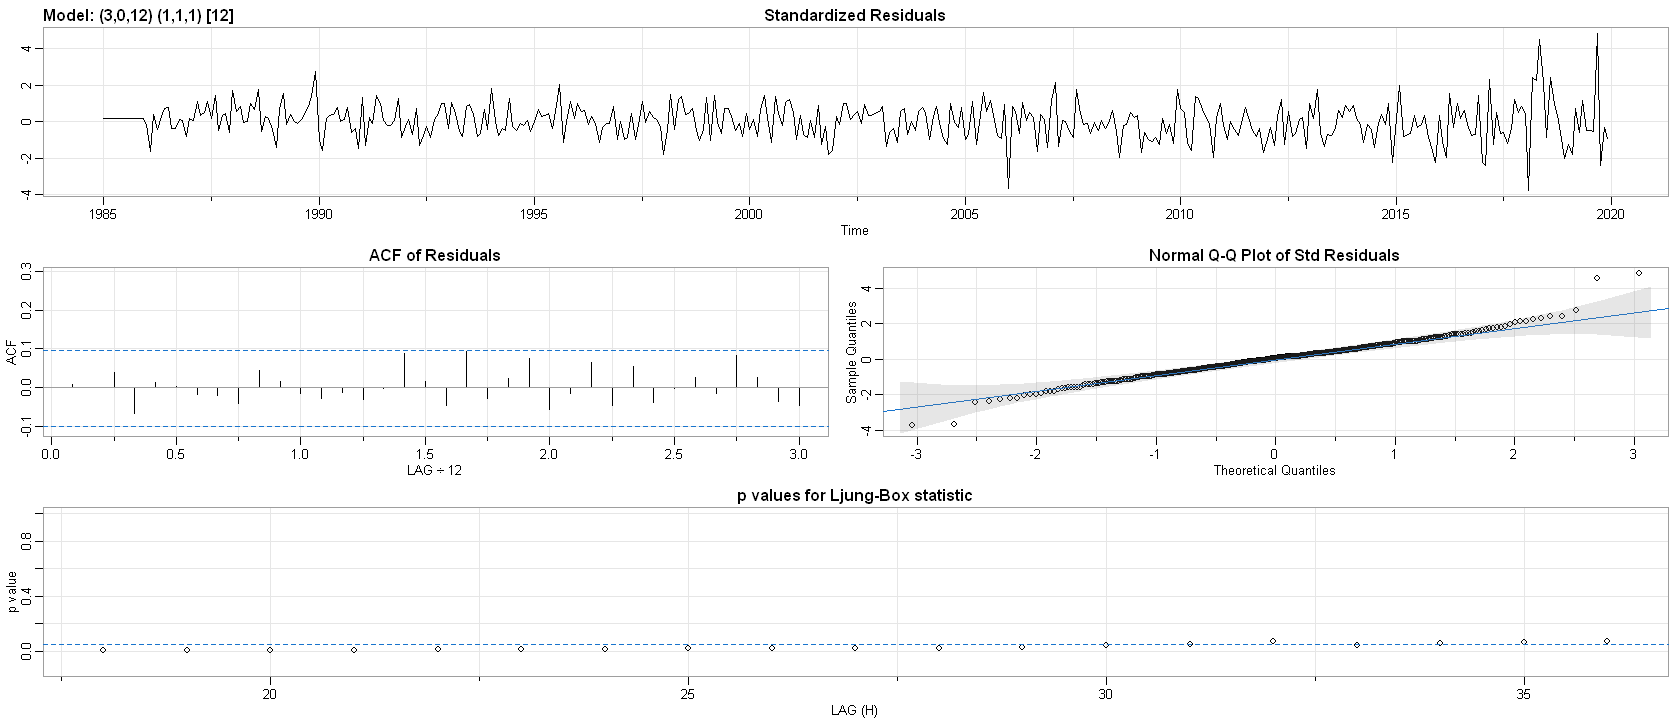

In [29]:
## SARIMA with p=3,d=0,q=12 & sp=1, sd=1,sq=1
sarima.consump = astsa::sarima(log.consumption.ts, 3,0,12, 1,1,1, 12)

### SARIMA Model: Residual Analysis

Here I am providing the residual analysis for the SARIMA model. 

- Except for a slight increase in the variability in the residuals over time, the residuals seem to be white noise, normally distributed. 
- On the bottom, I am providing the plot of the p-values for the Box-Ljung test for serial correlation for varying lag values. 

Note that we generally explore serial correlations for lags larger than the sum of the model orders. 

- From this plot, we see that the p-values for all lags are larger than the threshold 0.05, suggesting once again that it is plausible that the residuals are white noise.

### ARMA & Differencing vs SARIMA Model

Here I am comparing the estimated coefficients for the two models, the ARIMA model for the differenced time series and the SARIMA model.

In [30]:
# Coefficients ARMA
final_model


Call:
arima(x = diff.consump.train, order = c(porder, 0, qorder), method = "ML")

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ar6     ma1     ma2     ma3
      0.5653  -0.1662  0.1965  -0.2301  0.1300  -0.1414  0.1314  0.2100  0.0132
s.e.  0.1095   0.0825  0.0768   0.0825  0.0952   0.0771  0.1045  0.0973  0.0938
         ma4     ma5     ma6     ma7     ma8     ma9    ma10    ma11     ma12
      0.2198  0.0787  0.2334  0.1180  0.1361  0.0916  0.2191  0.1852  -0.6910
s.e.  0.0962  0.1129  0.1240  0.1043  0.0898  0.0785  0.0755  0.0962   0.1013
      intercept
         0.0174
s.e.     0.0038

sigma^2 estimated as 0.0006395:  log likelihood = 882.36,  aic = -1726.72

In [31]:
# Coefficients SARIMA
sarima_model_select3

$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
         ar1      ar2      ma1      ma2     ma3      ma4     ma5      ma6
      1.3836  -0.3875  -0.7204  -0.1238  0.0564  -0.0960  0.0381  -0.0087
s.e.  0.5192   0.5156   0.5184   0.1769  0.1564   0.0667  0.0812   0.0697
          ma7      ma8      ma9    ma10     ma11     ma12    sar1     sma1
      -0.0930  -0.0009  -0.0055  0.1964  -0.0593  -0.0779  0.1660  -0.8604
s.e.   0.0592   0.0815   0.0774  0.0691   0.1134   0.0854  0.0926   0.0390
      constant
        0.0015
s.e.    0.0004

sigma^2 estimated as 0.0006727:  log likelihood = 877.69,  aic = -1719.37

$degrees_of_freedom
[1] 379

$ttable
         Estimate     SE  t.value p.value
ar1        1.3836 0.5192   2.6650  0.0080
ar2       -0.3875 0.5156  -0.7516  0.4528
ma1       -0.7204 0.5184 

- First, I will point out that the estimated coefficients for the ARMA portion of the model are quite different; this is expected since these are two different models. 
- However, I will also note that the AIC value is quite similar, suggesting that the two models perform rather similar with respect to this criterion

### ARMA & Differencing: Forecasting

In the last part of this analysis, we will look at the forecasting accuracy of the two models. Here am providing the R code for deriving the forecast for the 12 months ahead along with the confidence bands. The code here is for comparing the observed time series for these 12 months to the predictions.

In [32]:
# Test and see if residuals are correlated
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))


	Box-Pierce test

data:  final_model$resid
X-squared = 6.7229, df = 1, p-value = 0.009518



	Box-Ljung test

data:  final_model$resid
X-squared = 6.9856, df = 1, p-value = 0.008217


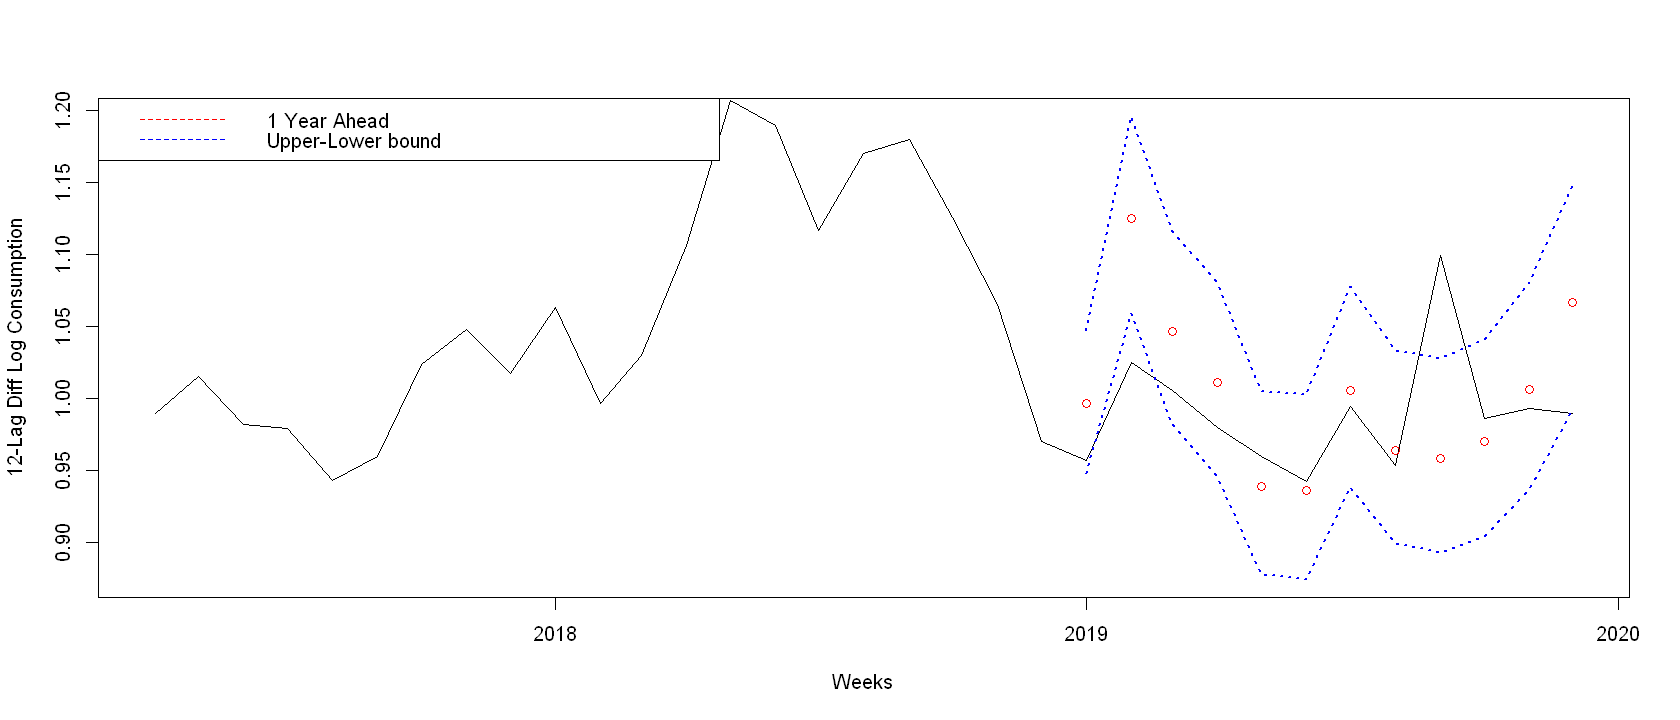

In [33]:
## Forecasting with ARMA, 1 Year (52 Weeks) Ahead: 
outpred = predict(final_model,n.ahead=n_forward)
ubound = outpred$pred+1.96*outpred$se #confidenec interval
lbound = outpred$pred-1.96*outpred$se
ymin = min(exp(lbound))
ymax = max(exp(ubound))
dates.diff = dates[-c(1:12)]
n = length(diff.consump)
plot((dates.diff)[(n-n_forward-20):n],exp(diff.consump[(n-n_forward-20):n]),type="l", 
     ylim=c(ymin,ymax), xlab="Weeks", ylab="12-Lag Diff Log Consumption")
points((dates.diff)[(nfit+1):n],exp(outpred$pred),col="red")
lines((dates.diff)[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines((dates.diff)[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("1 Year Ahead ","Upper-Lower bound"),lty = 2, col=c("red","blue"))

In [34]:
## Compute Accuracy Measures
consump_true = as.vector(exp(diff.consump[(nfit+1):n]))
consump_pred = exp(outpred$pred)
### Mean Squared Prediction Error (MSPE)
mean((consump_pred-consump_true)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(consump_pred-consump_true))
### Mean Absolute Percentage Error (MAPE)
mean(abs(consump_pred-consump_true)/consump_true)
### Precision Measure (PM)
sum((consump_pred-consump_true)^2)/sum((consump_true-mean(consump_true))^2)
### Does the observed data fall outside the prediction intervals?
sum(consump_true<exp(lbound))+sum(consump_true>exp(ubound))

[1] 0.003433309

[1] 0.04224065

[1] 0.0414053

[1] 2.141275

[1] 3

- From the plot above - The predictions follow the observed differenced data to some extent and all observations are within the prediction bands.
- **The precision is 2.1, meaning that we have twice as much variability in the prediction as in the observed data, an indication of a rather poor prediction**.

### SARIMA: Forecasting

Next I am evaluating the prediction of the SARIMA model. Note that here I am not using the standard predict command to obtain the predictions but the sarima.for() command that makes predictions one or more periods at time. For example here, the prediction is one period, or one year ahead.

In [35]:
nfit.sarima=length(log.consumption.ts)-12
n = length(log.consumption)
n
nfit.sarima

[1] 420

[1] 408

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2020,4.779255,4.673517,4.682705,4.578105,4.648429,4.727256,4.854868,4.824548,4.779333,4.640952,4.649571,4.729937


[1] 4.760288 4.621430 4.650160 4.561285 4.669567 4.740606 4.824725 4.799440
 [9] 4.850902 4.643371 4.633913 4.701305

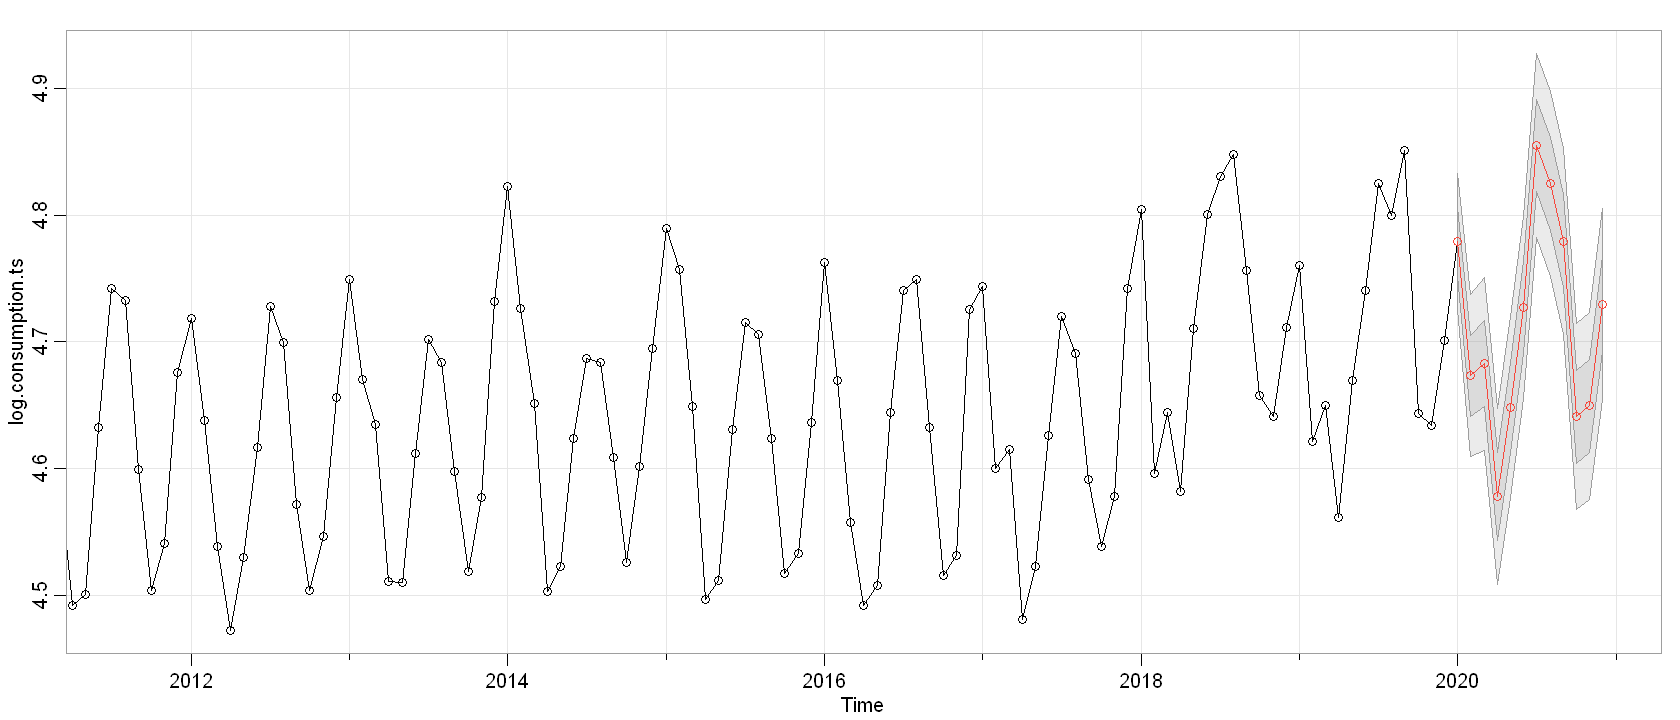

In [36]:
## Predict one year ahead
sarima_1year = sarima.for(log.consumption.ts, 12, 3,0,12, 1,1,1, 12)

pred_SARIMA = sarima_1year$pred
true_SARIMA =log.consumption.ts[(nfit.sarima+1):n]

pred_SARIMA
true_SARIMA

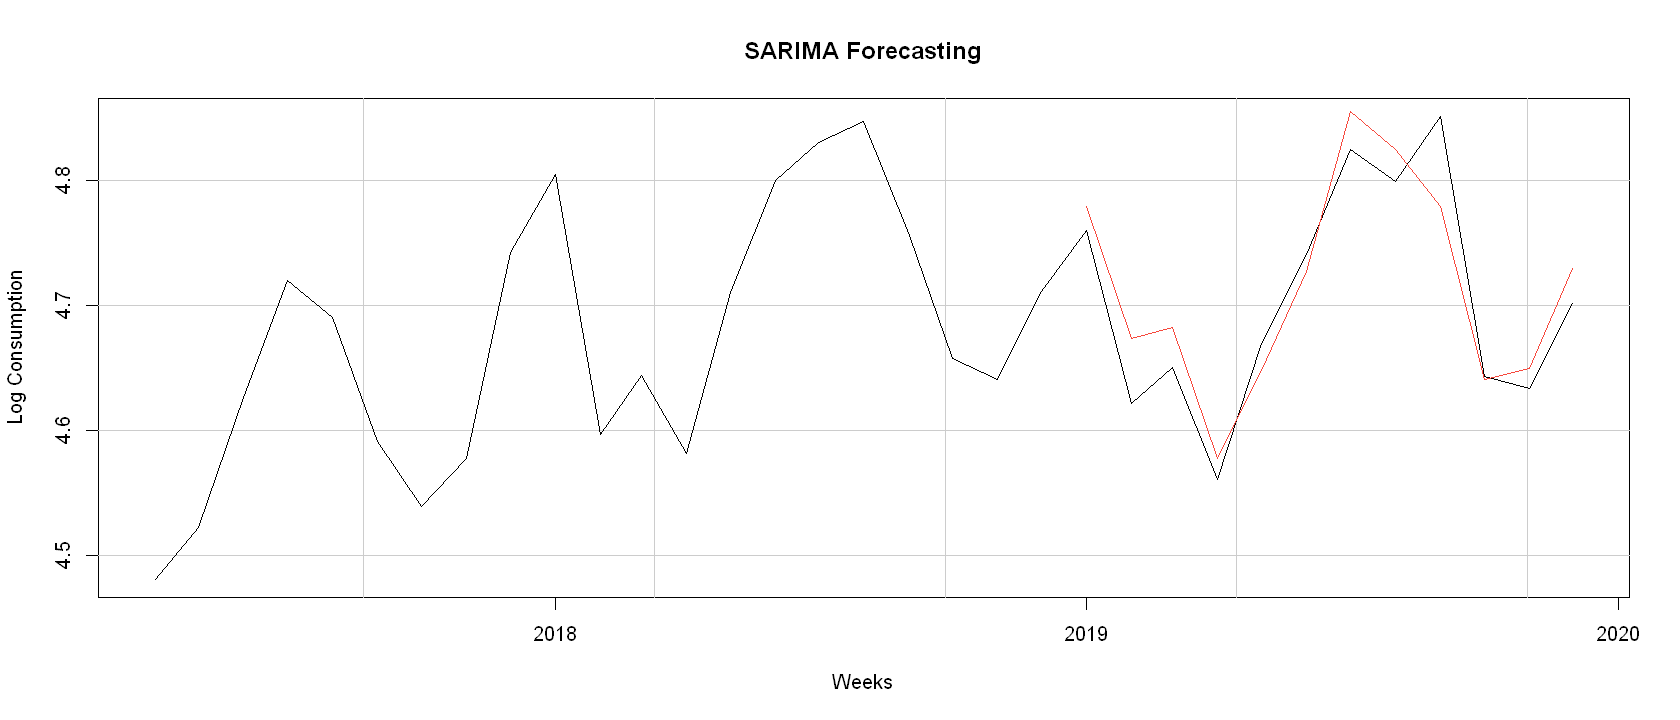

In [37]:
par(mfrow=c(1,1))
plot(dates[(n-n_forward-20):n],log.consumption.ts[(n-n_forward-20):n],type="l", 
     xlab="Weeks", ylab="Log Consumption",main="SARIMA Forecasting")
grid(lty=1, col=gray(.8))
lines(dates[(n-n_forward-20):n],log.consumption.ts[(n-n_forward-20):n])
lines(dates[(nfit.sarima+1):n],sarima_1year$pred, col=2)

In [38]:
## Accuracy Measures
### Mean Squared Prediction Error (MSPE)
mean((pred_SARIMA-true_SARIMA)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(pred_SARIMA-true_SARIMA))
### Mean Absolute Percentage Error (MAPE)
mean(abs(pred_SARIMA-true_SARIMA)/true_SARIMA)
### Precision Measure (PM)
sum((pred_SARIMA-true_SARIMA)^2)/sum((true_SARIMA-mean(true_SARIMA))^2)

[1] 0.001064326

[1] 0.02736976

[1] 0.005792291

[1] 0.1424958

Here is the plot along with the accuracy measures. 
- Both the plot and the accuracy measures show reasonably good predictions. 
- **The predictions follow the observed data to a great extent and the precision measure is 0.14, meaning that the prediction has only 14% of the variability in the data**.


This tells us that the prediction based on the SARIMA model is much better than that for the ARIMA model applied to the difference data. As an example, the precision measure for the ARMA was 2.14. One reason for this could be because the seasonality is the dominant part of the time series and here a model that incorporates prediction of the seasonality as well as the stationary process after accounting for seasonality would perform much better. Thus, in forecasting, it is recommended to use a seasonal ARIMA model if the model has seasonality and trend.

### End of Given code

### Forecasting Comparison Slide -

### ARMA model applied to the residuals removing the trend and seasonality

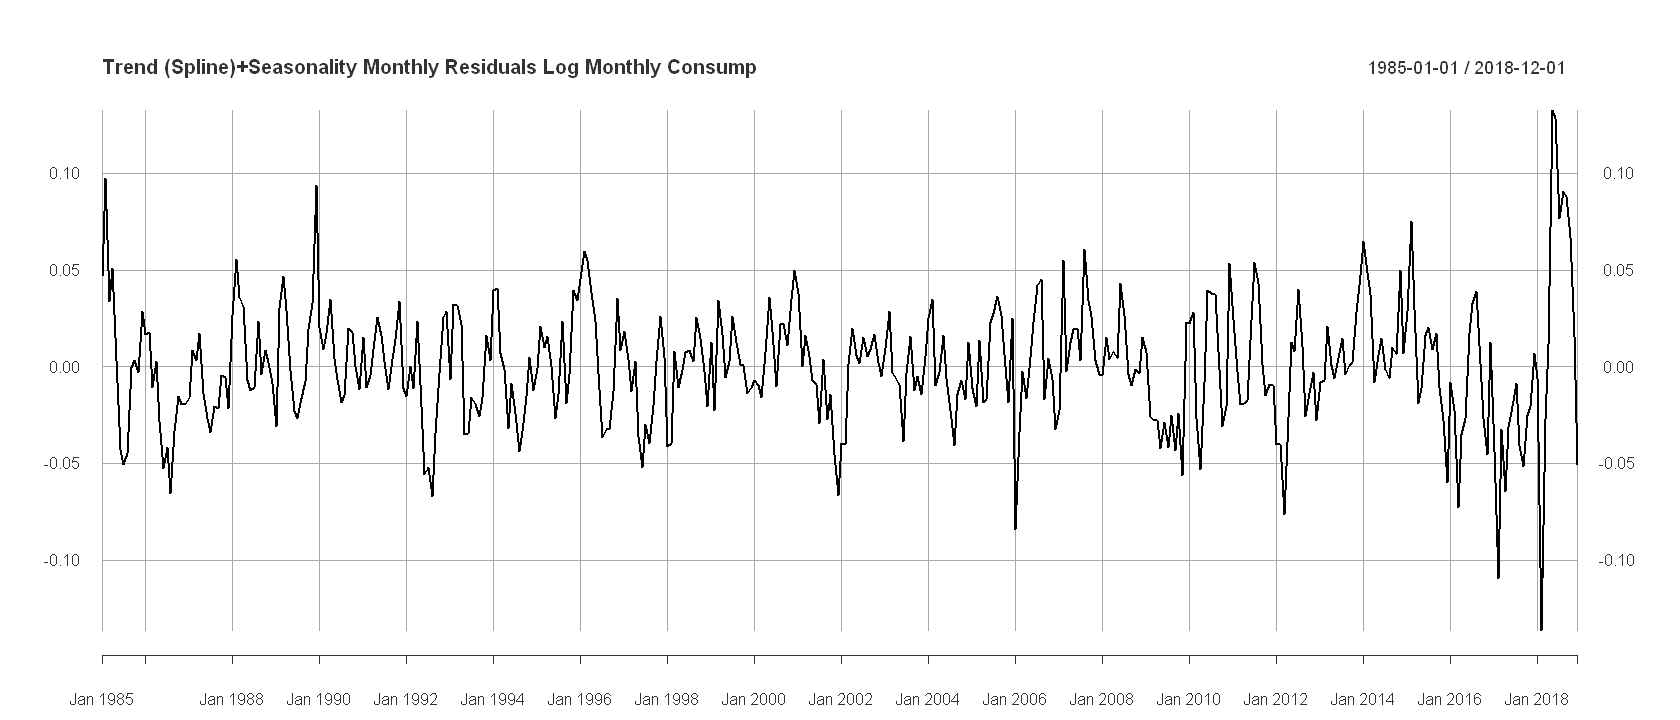

In [39]:
n_forward=12

arma_resid = log.consumption-log.fit.gam.monthtr

n = length(arma_resid)

nfit = n-n_forward

arma_resid.train = arma_resid[1:nfit]

plot(arma_resid.train, main="Trend (Spline)+Seasonality Monthly Residuals Log Monthly Consump")
grid(lty=1, col=gray(.8))

Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(arma_resid.train, order = c(p[i], 0, q[j]), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in stats::arima(arma_resid.train

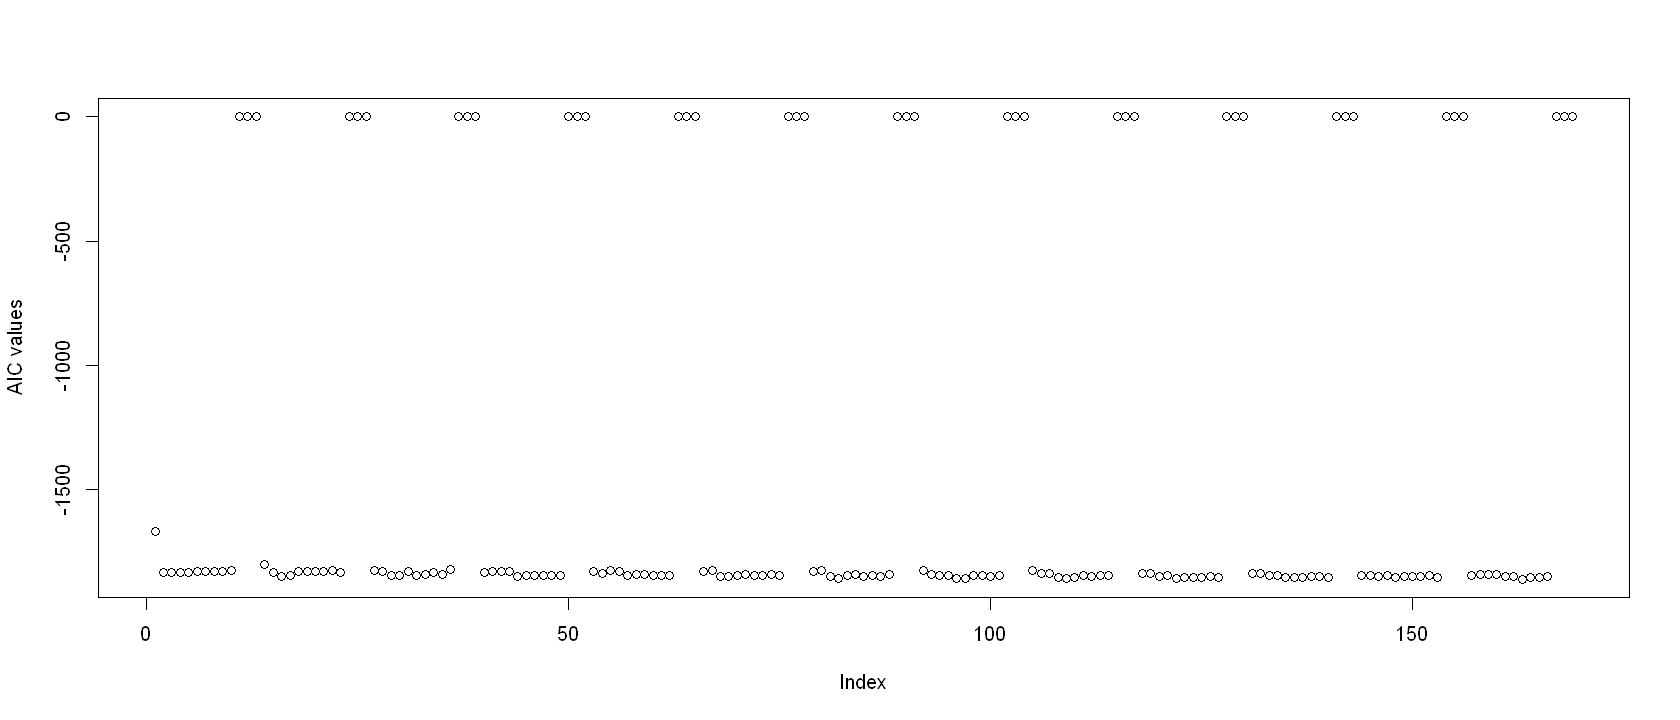

In [40]:
norder = 13
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)


## Fit an ARMA model to the Trend (Spline)+Seasonality Monthly Residuals time series with *d=0* 
n = length(arma_resid.train) 
norder = 13
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)

for(i in 1:10){
  for(j in 1:norder){
    modij = stats::arima(arma_resid.train, order = c(p[i],0,q[j]), method = 'ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
  }  
}
# Extract the "best" one according to AIC
aicv <- as.vector(aic)
plot(aicv,ylab="AIC values")
indexp <- rep(c(1:norder),norder)
indexq <- rep(c(1:norder),each=norder)
indexaic <- which(aicv == min(aicv))
porder <- indexp[indexaic]-1
qorder <- indexq[indexaic]-1

In [41]:
min(aicv)
porder
qorder

[1] -1859.049

[1] 6

[1] 12

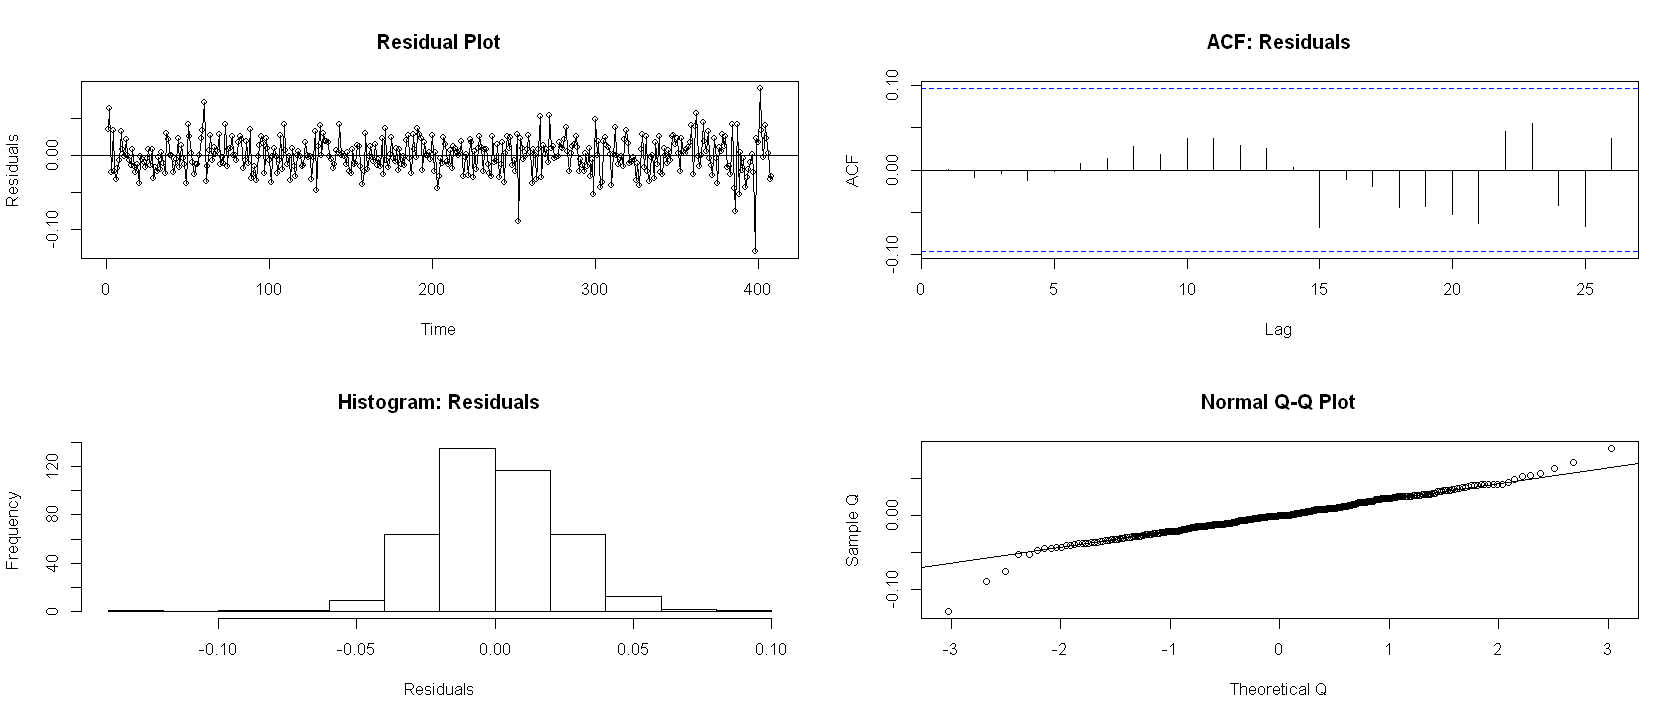

In [42]:
# Fit the "best" arima model
final_model <- arima(arma_resid.train, order = c(porder,0,qorder), method = "ML")

## GOF: residual analysis
par(mfrow=c(2,2))
resids <- resid(final_model)
plot(resids, ylab='Residuals',type='o',main="Residual Plot")
abline(h=0)
acf(resids,main="ACF: Residuals")
#pacf(resids,main="ACF: Residuals")
hist(resids,xlab='Residuals',main='Histogram: Residuals')
qqnorm(resids,ylab="Sample Q",xlab="Theoretical Q")
qqline(resids)

In [43]:
final_model


Call:
arima(x = arma_resid.train, order = c(porder, 0, qorder), method = "ML")

Coefficients:
          ar1     ar2     ar3      ar4     ar5     ar6     ma1      ma2
      -0.1677  0.4791  0.2393  -0.4319  0.0861  0.4170  0.7831  -0.0945
s.e.   0.2394  0.2913  0.1366   0.1920  0.1839  0.1746  0.2376   0.3245
          ma3     ma4      ma5      ma6      ma7      ma8      ma9     ma10
      -0.3814  0.1778  -0.0214  -0.5179  -0.4079  -0.3900  -0.3317  -0.0247
s.e.   0.2217  0.1851   0.2322   0.1176   0.0855   0.1006   0.1173   0.1415
        ma11    ma12  intercept
      0.0570  0.1516      0e+00
s.e.  0.1069  0.0993      2e-04

sigma^2 estimated as 0.0005418:  log likelihood = 950.5,  aic = -1863.01

In [44]:
# Test and see if residuals are correlated
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))


	Box-Pierce test

data:  final_model$resid
X-squared = 6.1601, df = 1, p-value = 0.01307



	Box-Ljung test

data:  final_model$resid
X-squared = 6.4116, df = 1, p-value = 0.01134


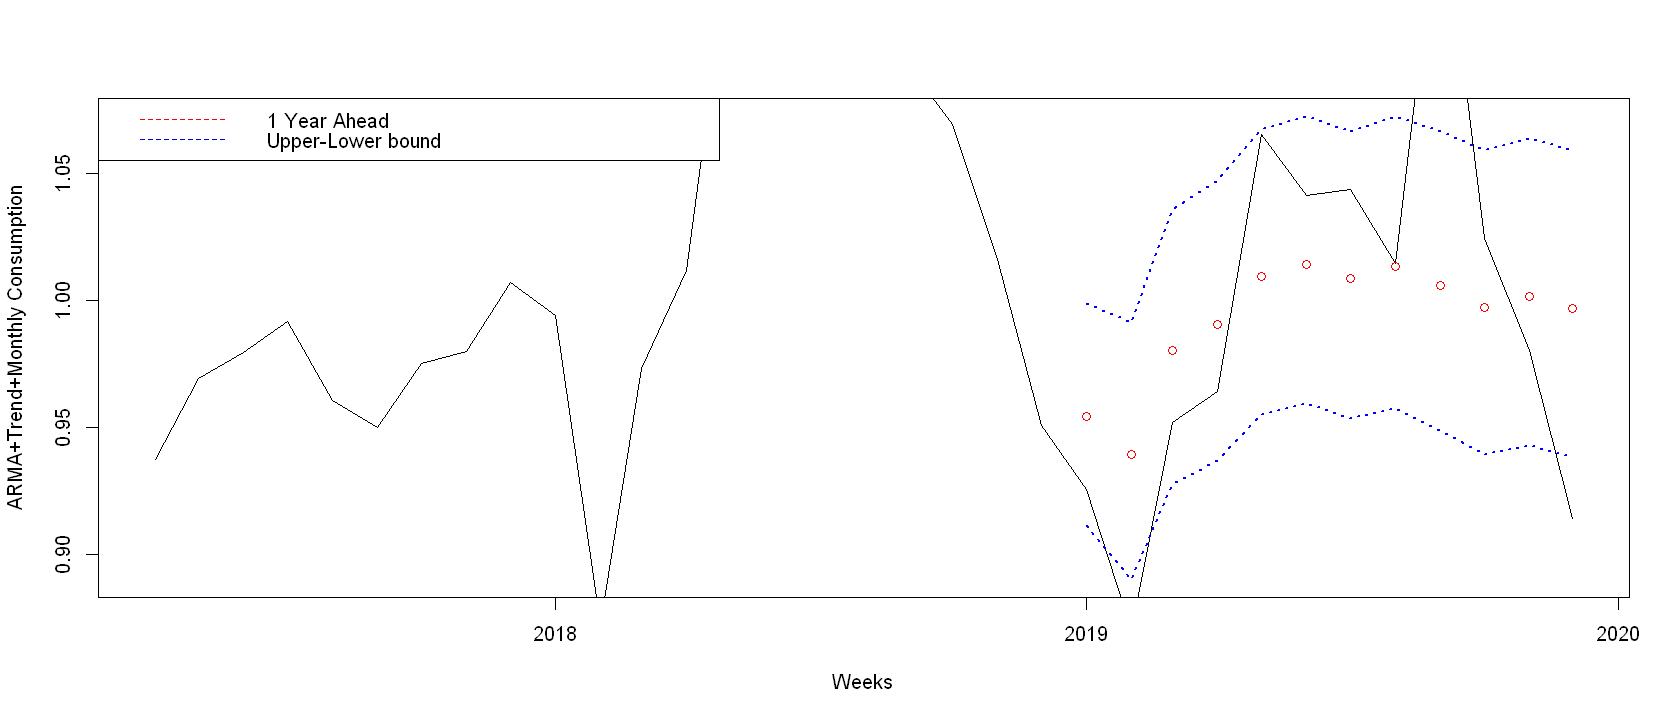

In [45]:
## Forecasting with ARMA, 1 Year (52 Weeks) Ahead: 
outpred = predict(final_model,n.ahead=n_forward)
ubound = outpred$pred+1.96*outpred$se #confidenec interval
lbound = outpred$pred-1.96*outpred$se
ymin = min(exp(lbound))
ymax = max(exp(ubound))
n = length(arma_resid)

plot((dates)[(n-n_forward-20):n],exp(arma_resid[(n-n_forward-20):n]),type="l", 
     ylim=c(ymin,ymax), xlab="Weeks", ylab="ARMA+Trend+Monthly Consumption")
points((dates)[(nfit+1):n],exp(outpred$pred),col="red")
lines((dates)[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines((dates)[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("1 Year Ahead ","Upper-Lower bound"),lty = 2, col=c("red","blue"))

In [46]:
## Compute Accuracy Measures
consump_true = as.vector(exp(arma_resid[(nfit+1):n]))
consump_pred = exp(outpred$pred)
### Mean Squared Prediction Error (MSPE)
mean((consump_pred-consump_true)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(consump_pred-consump_true))
### Mean Absolute Percentage Error (MAPE)
mean(abs(consump_pred-consump_true)/consump_true)
### Precision Measure (PM)
sum((consump_pred-consump_true)^2)/sum((consump_true-mean(consump_true))^2)
### Does the observed data fall outside the prediction intervals?
sum(consump_true<exp(lbound))+sum(consump_true>exp(ubound))

[1] 0.003828066

[1] 0.04689469

[1] 0.0463676

[1] 0.6563912

[1] 3